# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### Project Objective -- Define the problem

Here are the questions I would like to answer --

* What is the best offer for the overall target audience?
* What is/are the best offer(s) at an individual personalized level?
    * Based on Age
    * Based on Income
    * Based on Gender & Age
    * Based on Gender & Income
* Where do we have the opportunity to increase the number of offers being sent for certain demographics to increase sales?
* How much reward was given to individuals that did not view the offers sent to them?

There are three types of offers that are being sent: 
* Buy-One-Get-One (BOGO), 
* Discount, and 
* Informational 

For each of these offer types they further have subtypes. My focus in analyzing the datasets and trying to answer these questions would focus on BOGO and Discount types. 


In [1]:
#If Seaborn version 0.11.1 not installed, restart kernel & run this command
#!pip install seaborn==0.11.1

In [2]:
#check seaborn version
import seaborn as sns
sns.__version__

'0.11.1'

In [3]:
# Import libraries

import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

%matplotlib inline

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
#Provide column names with missing Values (NaN values) and missing % of Total Count
def missing_values(df):

    '''
    PARAMETERS:
    df - pandas dataframe that you want to evaluate for columns with count missing values and their percentages  

    RETURNS:
    mz_table - a dataframe with column names, count of missing values and the percentage of those missing values
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = { 0 : 'Missing Values', 1 : 'Missing % of Total Count'})
    
    return mz_table

### Understanding the Data
#### Portfolio, Profile, Transcript datasets
Check the following things about the dataset when getting started: <br>
    -- Look at the number of rows and columns in the dataset. <br>
    -- Check if there are missing values in any of the rows or columns. <br>
    -- Check if any columns are of different data types than you would expect (ex: numbers showing as strings) <br>
    -- Build exploratory plots to better understand the data. <br> <br>

#### Portfolio Dataset:

In [6]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
#get details in the dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
#check the columns that contain zero null values
portfolio.columns[np.sum(portfolio.isnull()) == 0]

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')

In [9]:
#run missing_value function to get the missing value count and %
missing_values(portfolio)

,Missing Values,Missing % of Total Count
channels,0,0.0
difficulty,0,0.0
duration,0,0.0
id,0,0.0
offer_type,0,0.0
reward,0,0.0


In [10]:
#check number of rows and columns in the dataset
portfolio.shape

(10, 6)

In [11]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

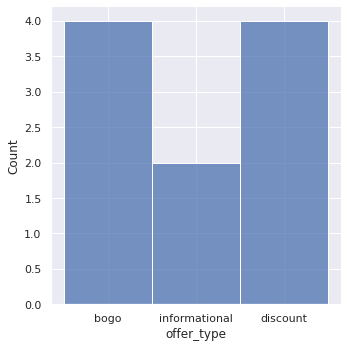

In [12]:
#create a chart to see income distribution in profile dataframe
sns.set()
sns.displot(data=portfolio, x="offer_type", height=5);

In [13]:
#sort the dataframe on offer_type
portfolio.sort_values('offer_type')

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


* We can see from above that the portfolio table consists of 10 entries that contains information about the offers provided by Starbucks. 
* There are 3 offers categories each then having sub groupings based on difficulty(minimum required spend to complete an offer), duration(time for offer to be open, in days), and reward(reward given for completing an offer).
* We can see a barchart containing a distribution of 3 offer types totalling in 10 entries.
* I will be adding an additional column to the table to define each offertype based on offer_type, difficulty, duration, and reward.

### Profile Dataset:

In [14]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


looking at the output above it looks like rows that we have rows with income and gender having null values also seem to have the age as 118. This needs to be evaluated further.

In [15]:
#get details in the dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [16]:
profile.shape

(17000, 5)

In [17]:
#check the columns that contain zero null values
profile.columns[np.sum(profile.isnull()) == 0]

Index(['age', 'became_member_on', 'id'], dtype='object')

In [18]:
#check foir missing values in profile dataframe
missing_values(profile)

,Missing Values,Missing % of Total Count
age,0,0.000000
became_member_on,0,0.000000
gender,2175,12.794118
id,0,0.000000
income,2175,12.794118


#### From the entries results above it looks like income and gender column have same number of missing values

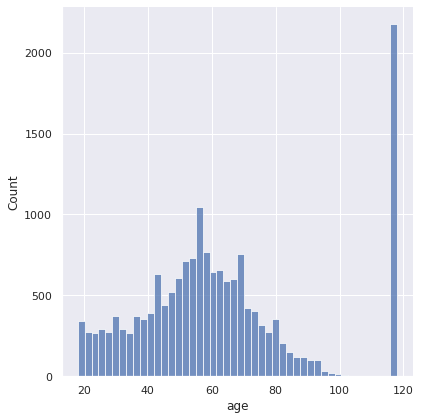

In [19]:
#create a chart to see age distribution in profile dataframe
sns.displot(data=profile, x="age", height=6);

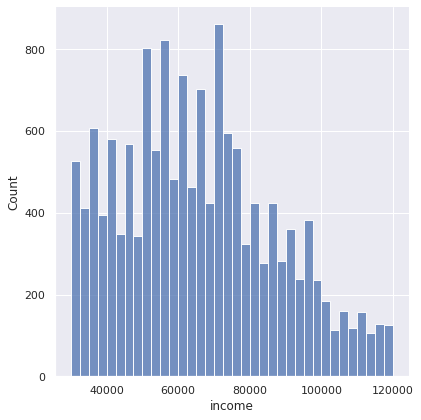

In [20]:
#create a chart to see income distribution in profile dataframe
sns.displot(data=profile, x="income", height=6);

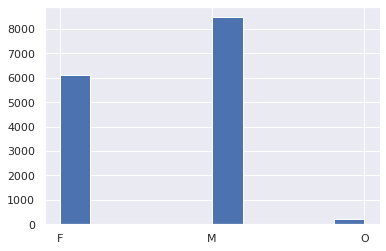

In [21]:
#create a chart to see age distribution in profile dataframe
profile.gender.hist();

In [22]:
profile.groupby('age')['id'].count()

age
18       70
19      135
20      135
21      140
22      131
23      126
24      139
25      136
26      157
27      139
28      137
29      129
30      131
31      113
32      139
33      152
34      147
35      118
36      175
37      197
38      172
39      182
40      202
41      189
42      227
43      215
44      192
45      231
46      212
47      232
       ... 
73      209
74      193
75      159
76      155
77      141
78      135
79      117
80      116
81      118
82      105
83      102
84       83
85       70
86       54
87       66
88       64
89       53
90       52
91       47
92       40
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      12
101       5
118    2175
Name: id, Length: 85, dtype: int64

In [23]:
profile.groupby('income')['id'].count()

income
30000.0      88
31000.0     223
32000.0     216
33000.0     213
34000.0     199
35000.0     206
36000.0     192
37000.0     209
38000.0     185
39000.0     209
40000.0     195
41000.0     204
42000.0     181
43000.0     169
44000.0     180
45000.0     196
46000.0     181
47000.0     192
48000.0     186
49000.0     157
50000.0     253
51000.0     268
52000.0     281
53000.0     282
54000.0     272
55000.0     254
56000.0     281
57000.0     288
58000.0     239
59000.0     243
           ... 
91000.0     106
92000.0     140
93000.0     132
94000.0     106
95000.0     126
96000.0     132
97000.0     124
98000.0     112
99000.0     123
100000.0     87
101000.0     48
102000.0     48
103000.0     59
104000.0     55
105000.0     58
106000.0     56
107000.0     45
108000.0     57
109000.0     62
110000.0     58
111000.0     55
112000.0     45
113000.0     54
114000.0     53
115000.0     50
116000.0     46
117000.0     32
118000.0     58
119000.0     54
120000.0     13
Name: id, Length:

In [24]:
profile.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

* Profile table consists of 17000 entries with 2175 null elements in the columns: gender and income.
* From the barcharts we can see the distribution of customers according to age, income, and gender.
* Based on age distribution we can see there are 85 age groups which includes age entry of 118 with a count of 2175.
* Based on income distribution we see there are 91 income groups.
* Based on gender distribution the Male(M) have slighty higer number than Female(F) while there is a small count of Other(O) category also present.
* For age 118 as well as the null entries in gender and income needs to be evaluated further and data needs to be cleaned.

### Transcript Dataset:

In [25]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [26]:
#get details in the dataset
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
transcript.shape

(306534, 4)

In [28]:
missing_values(transcript)

,Missing Values,Missing % of Total Count
event,0,0.0
person,0,0.0
time,0,0.0
value,0,0.0


In [29]:
#check the columns tht contain zero null values
transcript.columns[np.sum(transcript.isnull()) == 0]

Index(['event', 'person', 'time', 'value'], dtype='object')

In [30]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [31]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

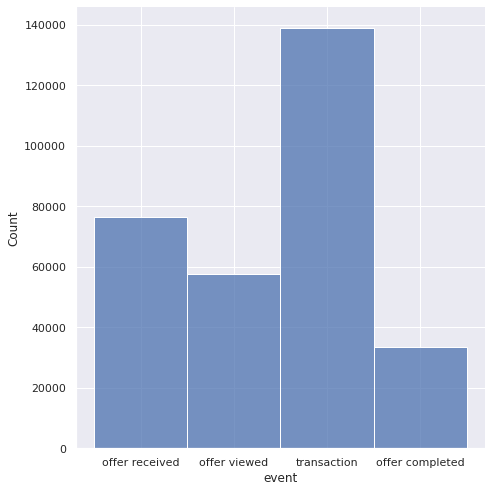

In [32]:
#create a chart to see event distribution in profile dataframe
sns.displot(data=transcript, x="event", height=7);

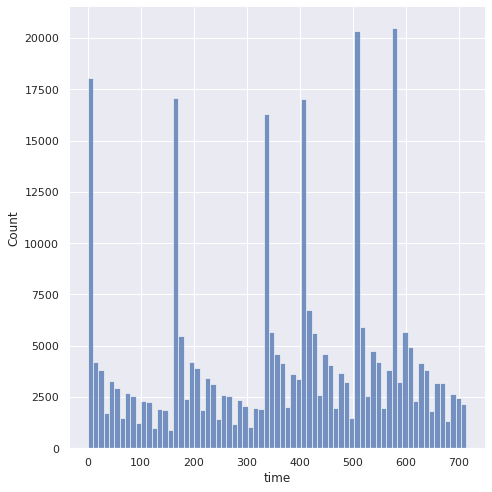

In [33]:
#create a chart to see time when events occur in profile dataframe
sns.displot(data=transcript, x="time", height=7);

* Transcript table consistes of 306534 entries.
* Event column has 4 unique values - offer received, offer viewed, transaction, offer completed.
* We can also see the distribution of the values in event column.
* From a timeline perspective, based on chart for time column, we also ge an idea on when those entries were created. It looks like there are 6 bigger spikes of events happening in this timeline. We will review this further in our analysis. 
* The way data is currently setup in value column will require cleaning.

### Analyzing and Cleaning the Data
#### Portfolio, Profile, Transcript datasets

#### Portfolio dataset

Since offer type is generic for different offers, I decided to add a column and make a label for each of the offer type that is specific/unique to that row.  Naming of the data in each row is "offer_type"-"difficulty"-"duration"-"reward" 

In [34]:
#adding column offertype
portfolio["offertype"] = np.nan
portfolio.loc[(portfolio.id == 'ae264e3637204a6fb9bb56bc8210ddfd'), 'offertype'] = 'bogo_10_7_10'
portfolio.loc[(portfolio.id == '4d5c57ea9a6940dd891ad53e9dbe8da0'), 'offertype'] = 'bogo_10_5_10'
portfolio.loc[(portfolio.id == '9b98b8c7a33c4b65b9aebfe6a799e6d9'), 'offertype'] = 'bogo_5_7_5'
portfolio.loc[(portfolio.id == 'f19421c1d4aa40978ebb69ca19b0e20d'), 'offertype'] = 'bogo_5_5_5'
portfolio.loc[(portfolio.id == '0b1e1539f2cc45b7b9fa7c272da2e1d7'), 'offertype'] = 'discount_20_10_5'
portfolio.loc[(portfolio.id == '2298d6c36e964ae4a3e7e9706d1fb8c2'), 'offertype'] = 'discount_7_7_3'
portfolio.loc[(portfolio.id == 'fafdcd668e3743c1bb461111dcafc2a4'), 'offertype'] = 'discount_10_10_2'
portfolio.loc[(portfolio.id == '2906b810c7d4411798c6938adc9daaa5'), 'offertype'] = 'discount_10_7_2'
portfolio.loc[(portfolio.id == '3f207df678b143eea3cee63160fa8bed'), 'offertype'] = 'info_0_4_0'
portfolio.loc[(portfolio.id == '5a8bc65990b245e5a138643cd4eb9837'), 'offertype'] = 'info_0_3_0'

In [35]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward,offertype
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_7_10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_5_10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,info_0_4_0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_7_5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_10_5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_7_3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_10_2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,info_0_3_0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_7_2


#### Profile dataset

Based on the earlier analysis of profile dataset, we will further investigate the records that have null values for gender and income columns.

In [36]:
#create dataset from profile which has null income and gender values
profile_gen_inc_null = profile[(profile['gender'].isnull()) & (profile['income'].isnull())]
profile_gen_inc_null.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [37]:
profile_gen_inc_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [38]:
profile_gen_inc_null.age.unique()

array([118])

In [39]:
#list out unique age entries in dataset that has null entries for income and gender
profile_gen_inc_null.groupby('age')['id'].count()

age
118    2175
Name: id, dtype: int64

Based on the above analysis it is clear that all the entries where gender and age are null, are associated with entries for age with value 118. Given that age 118 is way out of normal and that there is no associated income or gender for these values, to get a better representation of the demographics that need to be analyzed, I would delete these rows.

In [40]:
#delete rows from profile dataset where income is null
profile = profile.dropna(subset=['income'])
#call missing_value function to check the values in profile dataframe
missing_values(profile)

,Missing Values,Missing % of Total Count
age,0,0.0
became_member_on,0,0.0
gender,0,0.0
id,0,0.0
income,0,0.0


In [41]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [42]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


became_member_on column is of datatype integer. Since this needs to be a date, I will update the format of this column to datetime. 

In [43]:
#change became_member_on column to dattime format
profile['became_member_on'] =  pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

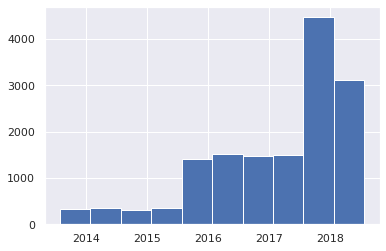

In [44]:
#create a chart to see became member on distribution in profile dataframe
profile.became_member_on.hist();

After the changes done to the dataset, I am going to look at the income and age column and review their distribution.

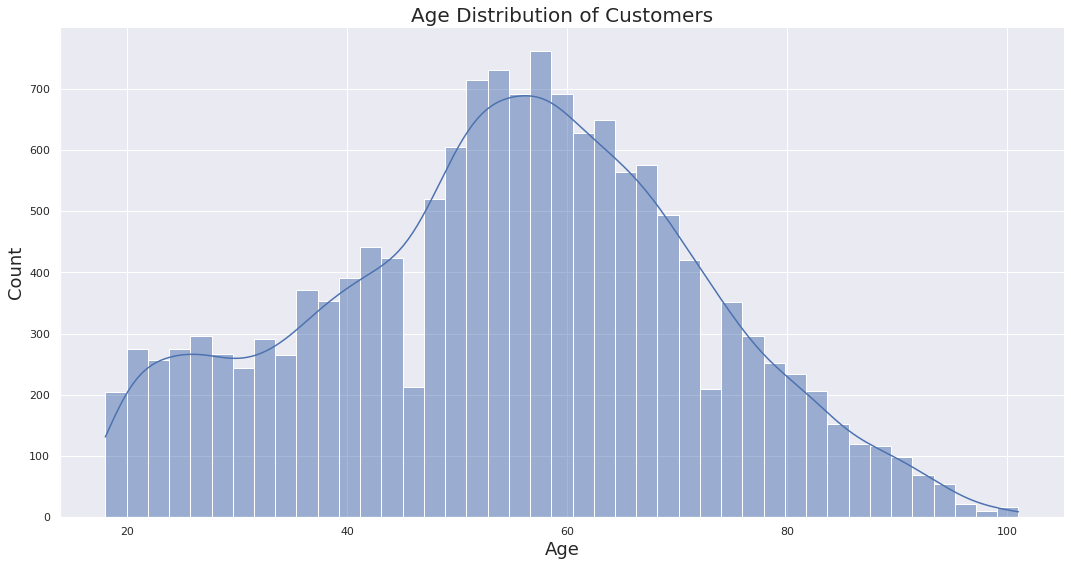

In [45]:
#plot a chart with count distubution for various ages
f, ax = plt.subplots(figsize=(18, 9))
ax.set_title('Age Distribution of Customers', fontsize=20)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.despine(f)
sns.histplot(data=profile, x="age", kde=True);


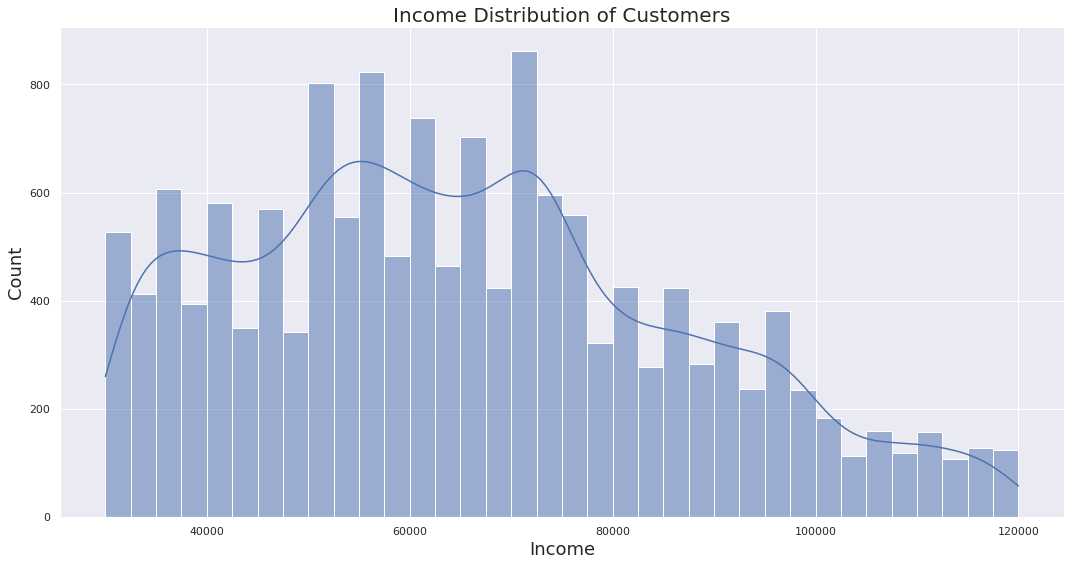

In [46]:
#plot a chart with count distubution for various income
f, ax = plt.subplots(figsize=(18, 9))
ax.set_title('Income Distribution of Customers', fontsize=20)
ax.set_xlabel('Income', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.despine(f)
sns.histplot(data=profile, x="income", kde=True);

Based on the updated dataset, we can see that:
* Income distribution is higher between 50-80K. It starts to taper off as the income increases.
* Age distribution is concentrated between 40-75.


In [47]:
# What is the last date when someone became member on, in the current dataset  
profile_temp_member_date = profile.sort_values('became_member_on', ascending=False)
profile_temp_member_date.head()

,age,became_member_on,gender,id,income
12326,59,2018-07-26,F,3b9ec536e4224688950913b9cf53362c,88000.0
12102,55,2018-07-26,F,f69e66bb9d2e41eaa2aacbaa18632c08,65000.0
12560,49,2018-07-26,F,464738f7360847adb55de84c859ba8af,50000.0
10282,46,2018-07-26,M,e4989ca3d8974e28a3fe87aa0b0ce327,74000.0
8079,82,2018-07-26,M,039e0c539c2f4fc582423412a8bceb40,32000.0


In [48]:
print('Latest date when someone became member is: ' + str(profile_temp_member_date['became_member_on'].iloc[0]))


Latest date when someone became member is: 2018-07-26 00:00:00


#### Transcript dataset

Transcript dataset has time column which has starting at 0 events tagged on when they occured. I queried the information above from profile dataset and have 2018-07-26 as the latest date when a customer registered and became member. I am adding a new column in transcript dataset, event_datetime and associating it with 0 hr value. Hrs will be added to it to get the datetime for events that occured later in the time. 

I am also adding another column, transcript_index in the dataset that I will be using for sorting data in the dataframe later. Value of this column will be same as the index value of dataframe.

In [49]:
#Add a column event_datetime and start on 8/1/2018 (assumption). The date was taken as a future date after the last member 
#joined. Hrs are added to this column to get the date when the event would have happened
transcript['event_datetime'] = pd.to_datetime('2018-08-01') + pd.to_timedelta(transcript.time, unit='h')

In [50]:
#add a column transcript_index that is replicated from the index of the dataframe
transcript['transcript_index'] = transcript.index

In [51]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
value               306534 non-null object
event_datetime      306534 non-null datetime64[ns]
transcript_index    306534 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 14.0+ MB


In [52]:
transcript.head()

,event,person,time,value,event_datetime,transcript_index
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-01,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2018-08-01,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2018-08-01,2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2018-08-01,3
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2018-08-01,4


In [53]:
#List out all the person with the number of rows for each of them in transcript dataframe
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
b1f4ece7d49342628a9ed77aee2cde58    46
bd2cdd691aca4bb0a0e039979ee5de5c    46
28681c16026943e68f26feaccab0907f    46
a42ed50acc4d4b25bca647c9e0b916ad    46
ab25fd6fbd5040f880751921e4029757    44
d087fd0166404163b7d1e1e7cf2a9ac7    43
9ae56116908640fc83477982da0aaec4    43
86e9d338b85b4177b369fe6b0ad4fed3    43
ca265792e65949d79b2b0e91bdd31c57    43
4142f5e23db741b1af4be0287dc91c1c    43
0d74b166a5e54b269795dbaf38c6dfae    42
40ce078d5b2a43d19138a788754520be    42
8e7d398d4bd948e397e201ad2bd5cce8    42
cd9bac9e8aea4609929a55b9b468c88e    42
edc7b04392144da9979f3077095f268a    42
0ebc3c4c39234ab6a2701fe2525705a9    42
6cd32ababc644c6c8a2644368c795728    41
562b9efc809b4bd897ce0381347aaea2    41
81a263ee0b8544b6a8910ee690cc6edd    41
2ddc7d63c32d4606a7a45e3e70439b44    41
f0a3a3c05e3c4e2e84929a49a

From the query results above I selected one individual to get more information and better understaing about their entries. Selected one with max(51) entries.

In [54]:
#person who has max 51 entry in transcript dataset
#Evaluate the entries to better understand the dataset
transcript[transcript['person'] == '94de646f7b6041228ca7dec82adb97d2']

,event,person,time,value,event_datetime,transcript_index
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2018-08-01 00:00:00,2276
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2018-08-01 06:00:00,16010
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41},2018-08-02 06:00:00,24531
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,2018-08-02 06:00:00,24532
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47},2018-08-05 06:00:00,42252
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-08 00:00:00,55475
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-08 18:00:00,75256
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62},2018-08-09 00:00:00,77624
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59},2018-08-09 12:00:00,81725
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002},2018-08-11 06:00:00,93913


Reviewing the result above we get an idea on how the events are occuring. Based in this we can construct the sequence of events that would lead to successful outcome as well as other possible sequences

For BOGO & discount offers, a successful outcome would have the following sequence in the defiled timeframe:

* offer received -> offer viewed -> transaction(s) -> offer completed 

Scenario where customers received offer but did not successfully convert

* offer received -> offer viewed
* offer received

Scenario where customers are not aware of the offer 

* transaction(s)
* offer received -> transaction(s) -> offer completed -> offer viewed
* transaction(s) -> offer received -> offer completed -> offer viewed
* transaction(s) -> offer received -> offer completed
* offer received -> transaction(s) -> offer viewed -> offer completed
 

Reviewing the value column shows us following values:
* If the event is "offer received" then we see value column has offer id entry and an associated id
* If the event is "offer viewed" then we see value column has offer id entry and an associated id
* If the event is "offer completed" then we see value column has offer id entry and an associated id
* If the event is "transaction" then we see amount and a numeric value of the transaction amount
* There are two different text entries for offer id in values field
    * "offer_id" - This seem to be in offer received and offer viewed rows
    * "offer id" - This seems to be in offer completed rows


In [55]:
#converting time entries into columns to analyze as to when did the event happen in the overall timeline
#Burst of offer and spike in spend

transcript_hrs = pd.concat([transcript, pd.get_dummies(transcript.time)], axis=1)
transcript_hrs.head()

,event,person,time,value,event_datetime,transcript_index,0,6,12,18,...,660,666,672,678,684,690,696,702,708,714
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-01,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2018-08-01,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2018-08-01,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2018-08-01,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2018-08-01,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
#delete columns from transcript_hrs to futher evaluate the events 
transcript_hrs.drop(['person', 'time', 'value', 'event_datetime', 'transcript_index'], axis=1, inplace=True)

df_transcript_hrs = transcript_hrs.groupby(['event']).sum()
df_transcript_hrs_t = df_transcript_hrs.T #transpose dataframe

#add evt column in dataframe which is copy of the index of dataframe
df_transcript_hrs_t['evt'] = df_transcript_hrs_t.index 

In [57]:
df_transcript_hrs_t.head(10)

event,offer completed,offer received,offer viewed,transaction,evt
0,206.0,12650.0,2072.0,633.0,0
6,276.0,0.0,1433.0,797.0,6
12,280.0,0.0,1085.0,850.0,12
18,252.0,0.0,884.0,879.0,18
24,265.0,0.0,734.0,922.0,24
30,275.0,0.0,593.0,1028.0,30
36,258.0,0.0,474.0,1000.0,36
42,227.0,0.0,367.0,1056.0,42
48,234.0,0.0,316.0,1060.0,48
54,224.0,0.0,280.0,1015.0,54


In [58]:
def plot_chart_trans_hrs(df_transcript_hrs_t, var_or, var_ov, var_oc, var_t):

    '''
    Generates a chart based on the condition provided
    
    PARAMETERS:
        Dataframe and boolean values for offer recieved, offer viewed, offer completed and transaction
    
    RETURNS:
        None
    '''
    
    #plot a graph that displays events on the timeline 
    f, ax = plt.subplots(figsize=(18, 9))
    ax = plt.gca()

    if var_or:
        df_transcript_hrs_t.plot(kind='line',x='evt',y='offer received', color='blue', ax=ax)
    if var_ov:
        df_transcript_hrs_t.plot(kind='line',x='evt',y='offer viewed', color='red', ax=ax)
    if var_oc:
        df_transcript_hrs_t.plot(kind='line',x='evt',y='offer completed', color='green', ax=ax)
    if var_t:
        df_transcript_hrs_t.plot(kind='line',x='evt',y='transaction', color='brown', ax=ax)

    plt.show()
    

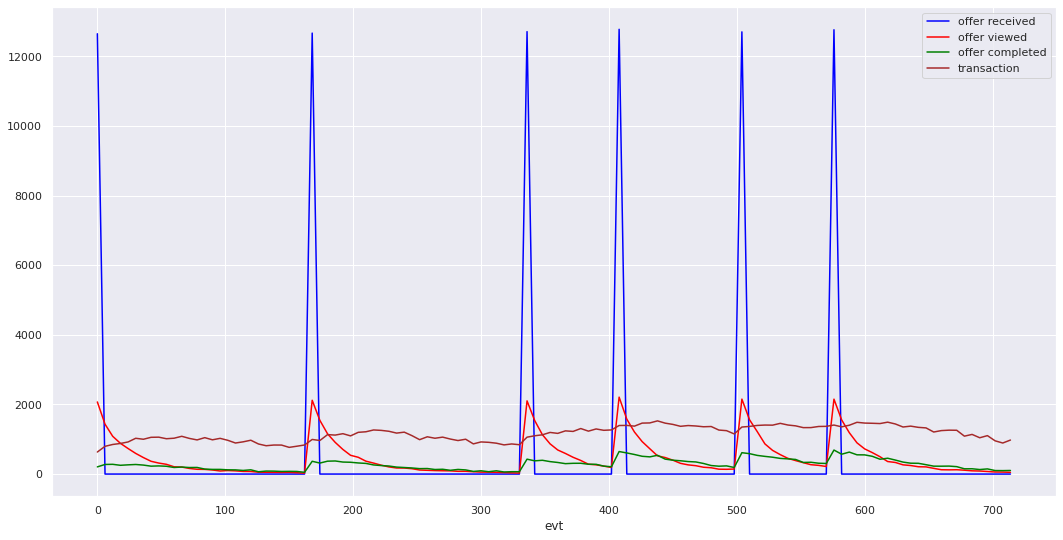

In [59]:
#plot chart for all events
plot_chart_trans_hrs(df_transcript_hrs_t, True, True, True, True)

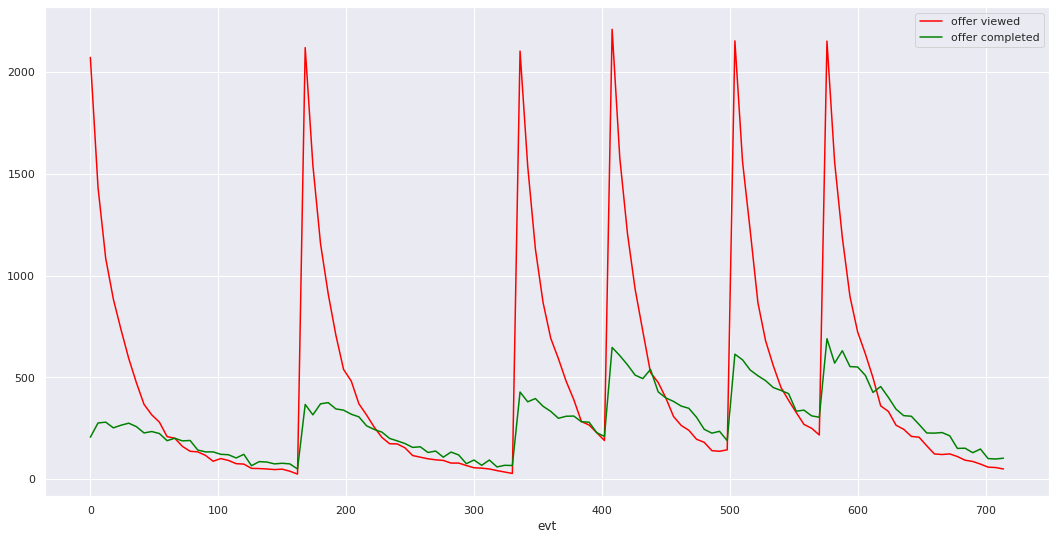

In [60]:
#Is there coorelation seen between offer viewed and offer completed
plot_chart_trans_hrs(df_transcript_hrs_t, False, True, True, False)

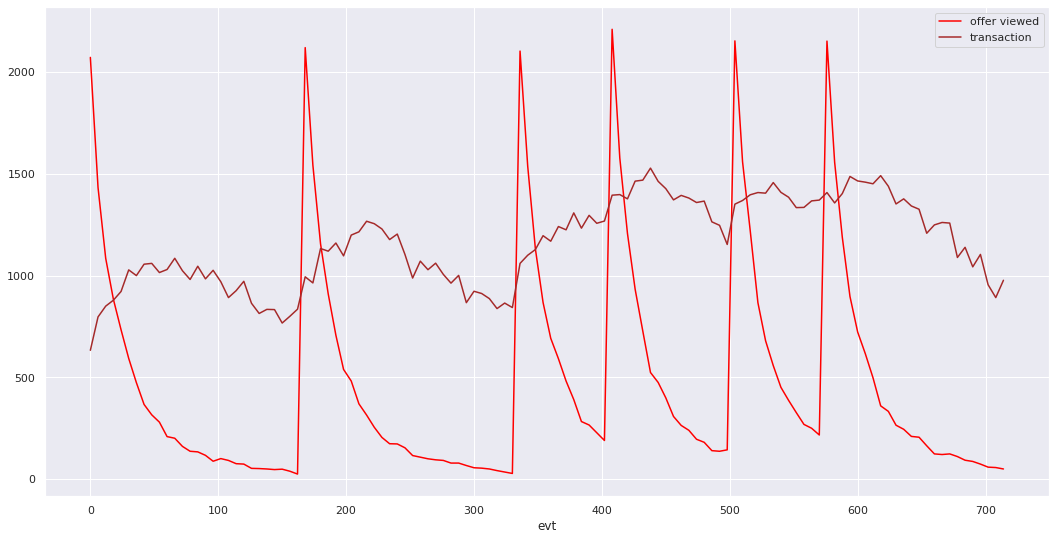

In [61]:
#How are transactions impacted after offer viewed event
plot_chart_trans_hrs(df_transcript_hrs_t, False, True, False, True)

From the charts above it can be seen that:
* A spike in offer recieved is followed by a spike in offer viewed also. This clearly shows that customers are viewing offers after they get it.
* We also see a spike in offer completed which seems to be following offer viewed.
* There is a spike in transactations but this it seems to be somewhat influenced by the offer events.

In [62]:
#Creating flag columns based on event column entries
transcript = pd.concat([transcript, pd.get_dummies(transcript.event)], axis=1)

In [63]:
transcript.head(5)

,event,person,time,value,event_datetime,transcript_index,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-01,0,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2018-08-01,1,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2018-08-01,2,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2018-08-01,3,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2018-08-01,4,0,1,0,0


In [64]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 10 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
value               306534 non-null object
event_datetime      306534 non-null datetime64[ns]
transcript_index    306534 non-null int64
offer completed     306534 non-null uint8
offer received      306534 non-null uint8
offer viewed        306534 non-null uint8
transaction         306534 non-null uint8
dtypes: datetime64[ns](1), int64(2), object(3), uint8(4)
memory usage: 15.2+ MB


In [65]:
#Renaming columns from event data
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 
                           'offer viewed': 'offer_viewed'}, inplace=True)

In [66]:
#expanding value column
#code for adding values split 'value 'columns into transcript dataframe 
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [67]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 14 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
value               306534 non-null object
event_datetime      306534 non-null datetime64[ns]
transcript_index    306534 non-null int64
offer_completed     306534 non-null uint8
offer_received      306534 non-null uint8
offer_viewed        306534 non-null uint8
transaction         306534 non-null uint8
offer id            134002 non-null object
amount              138953 non-null float64
offer_id            33579 non-null object
reward              33579 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5), uint8(4)
memory usage: 24.6+ MB


In [68]:
transcript.head()

,event,person,time,value,event_datetime,transcript_index,offer_completed,offer_received,offer_viewed,transaction,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2018-08-01,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2018-08-01,1,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2018-08-01,2,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2018-08-01,3,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2018-08-01,4,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


We can see that we now have two columns, "offer id" and "offer_id". I will now validate that the observation above is correct
* The observation I had above was: There are two different text entries for offer id in values field
    * "offer_id" - This seem to be in offer received and offer viewed rows
    * "offer id" - This seems to be in offer completed rows


In [69]:
#create this dataframe to check if there is any entry in "offer_id" colunm when "offer id" is not null
transcript_oc_test1 = transcript.loc[transcript['offer id'].notnull()]
transcript_oc_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134002 entries, 0 to 306507
Data columns (total 14 columns):
event               134002 non-null object
person              134002 non-null object
time                134002 non-null int64
value               134002 non-null object
event_datetime      134002 non-null datetime64[ns]
transcript_index    134002 non-null int64
offer_completed     134002 non-null uint8
offer_received      134002 non-null uint8
offer_viewed        134002 non-null uint8
transaction         134002 non-null uint8
offer id            134002 non-null object
amount              0 non-null float64
offer_id            0 non-null object
reward              0 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5), uint8(4)
memory usage: 11.8+ MB


In [70]:
#create this dataframe to check if there is any entry in "offer id" colunm when "offer_id" is not null
transcript_oc_test2 = transcript.loc[transcript['offer_id'].notnull()]
transcript_oc_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 12658 to 306527
Data columns (total 14 columns):
event               33579 non-null object
person              33579 non-null object
time                33579 non-null int64
value               33579 non-null object
event_datetime      33579 non-null datetime64[ns]
transcript_index    33579 non-null int64
offer_completed     33579 non-null uint8
offer_received      33579 non-null uint8
offer_viewed        33579 non-null uint8
transaction         33579 non-null uint8
offer id            0 non-null object
amount              0 non-null float64
offer_id            33579 non-null object
reward              33579 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5), uint8(4)
memory usage: 2.9+ MB


From the two dataframe created and their info reviewed, we can see that:
* When "offer_id" is not null, all corresponding values in those rows for "offer id" columns are null
* When "offer id" is not null, all corresponding values in those rows for "offer_id" columns are null

Based on this we can safely merge the two columns into one without interfering in the present values for each row.

In [71]:
#Merge offer_id and offer id columns into one
transcript['temp_offer_id'] = transcript['offer_id'].fillna(transcript['offer id']) 
# drop the three columns value, offer_id and offer id
transcript.drop(['offer_id', 'offer id', 'value'], axis=1, inplace=True)
#rename columns temp_offer_id to offer_id
transcript.rename(columns={'temp_offer_id': 'offer_id'}, inplace=True)
transcript.head()

,event,person,time,event_datetime,transcript_index,offer_completed,offer_received,offer_viewed,transaction,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,2018-08-01,0,0,1,0,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,2018-08-01,1,0,1,0,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2018-08-01,2,0,1,0,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,2018-08-01,3,0,1,0,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,2018-08-01,4,0,1,0,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [72]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 12 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
event_datetime      306534 non-null datetime64[ns]
transcript_index    306534 non-null int64
offer_completed     306534 non-null uint8
offer_received      306534 non-null uint8
offer_viewed        306534 non-null uint8
transaction         306534 non-null uint8
amount              138953 non-null float64
reward              33579 non-null float64
offer_id            167581 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(3), uint8(4)
memory usage: 19.9+ MB


In [73]:
#rename columns in portfolio, profile and transcript dataframes 
#merge the dataframes to prep for analyzing the data

portfolio.rename(columns={'reward': 'offer_reward'}, inplace=True)
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
profile.rename(columns={'id': 'person_id'}, inplace=True)
transcript.rename(columns={'person': 'person_id'}, inplace=True)
#prof_tran is merged dataset between transcript and profile
prof_trans = pd.merge(transcript, profile, on='person_id', how='outer')

In [74]:
prof_trans.head()

,event,person_id,time,event_datetime,transcript_index,offer_completed,offer_received,offer_viewed,transaction,amount,reward,offer_id,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,2018-08-01 00:00:00,0,0,1,0,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,2018-08-01 06:00:00,15561,0,0,1,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,2018-08-06 12:00:00,47582,0,0,0,1,19.89,NaN,NaN,75.0,2017-05-09,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,2018-08-06 12:00:00,47583,1,0,0,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,2018-08-07 00:00:00,49502,0,0,0,1,17.78,NaN,NaN,75.0,2017-05-09,F,100000.0


In [75]:
prof_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 16 columns):
event               306534 non-null object
person_id           306534 non-null object
time                306534 non-null int64
event_datetime      306534 non-null datetime64[ns]
transcript_index    306534 non-null int64
offer_completed     306534 non-null uint8
offer_received      306534 non-null uint8
offer_viewed        306534 non-null uint8
transaction         306534 non-null uint8
amount              138953 non-null float64
reward              33579 non-null float64
offer_id            167581 non-null object
age                 272762 non-null float64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(4), uint8(4)
memory usage: 31.6+ MB


In [76]:
missing_values(prof_trans)

,Missing Values,Missing % of Total Count
event,0,0.000000
person_id,0,0.000000
time,0,0.000000
event_datetime,0,0.000000
transcript_index,0,0.000000
offer_completed,0,0.000000
offer_received,0,0.000000
offer_viewed,0,0.000000
transaction,0,0.000000
amount,167581,54.669629


We see that income column has 33772 entries have null values. Since we had all rows for income column as not null in profile dataset after the deletion of null values, these 33772 entries are related to the profiles that were with age 118 and income as null. Deleting these entries from the prof_tran dataframe.

In [77]:
#Deleting these entries from the prof_tran dataframe
prof_trans = prof_trans.dropna(subset=['income'])

In [78]:
missing_values(prof_trans)

,Missing Values,Missing % of Total Count
event,0,0.000000
person_id,0,0.000000
time,0,0.000000
event_datetime,0,0.000000
transcript_index,0,0.000000
offer_completed,0,0.000000
offer_received,0,0.000000
offer_viewed,0,0.000000
transaction,0,0.000000
amount,148805,54.554887


In [79]:
prof_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 16 columns):
event               272762 non-null object
person_id           272762 non-null object
time                272762 non-null int64
event_datetime      272762 non-null datetime64[ns]
transcript_index    272762 non-null int64
offer_completed     272762 non-null uint8
offer_received      272762 non-null uint8
offer_viewed        272762 non-null uint8
transaction         272762 non-null uint8
amount              123957 non-null float64
reward              32444 non-null float64
offer_id            148805 non-null object
age                 272762 non-null float64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(4), uint8(4)
memory usage: 28.1+ MB


In [80]:
# merge prof_tran and portfolio datframes
port_prof_trans = pd.merge(prof_trans, portfolio, on='offer_id', how='outer')

In [81]:
port_prof_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 22 columns):
event               272762 non-null object
person_id           272762 non-null object
time                272762 non-null int64
event_datetime      272762 non-null datetime64[ns]
transcript_index    272762 non-null int64
offer_completed     272762 non-null uint8
offer_received      272762 non-null uint8
offer_viewed        272762 non-null uint8
transaction         272762 non-null uint8
amount              123957 non-null float64
reward              32444 non-null float64
offer_id            148805 non-null object
age                 272762 non-null float64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
channels            148805 non-null object
difficulty          148805 non-null float64
duration            148805 non-null float64
offer_type          148805 non-null object
offer_reward  

In [82]:
port_prof_trans.head()

,event,person_id,time,event_datetime,transcript_index,offer_completed,offer_received,offer_viewed,transaction,amount,...,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,offer_reward,offertype
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,2018-08-01 00:00:00,0,0,1,0,0,NaN,...,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_5_7_5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,2018-08-01 06:00:00,15561,0,0,1,0,NaN,...,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_5_7_5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,2018-08-06 12:00:00,47583,1,0,0,0,NaN,...,75.0,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_5_7_5
3,offer received,e2127556f4f64592b11af22de27a7932,408,2018-08-18 00:00:00,150600,0,1,0,0,NaN,...,68.0,2018-04-26,M,70000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_5_7_5
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,2018-08-18 12:00:00,171209,0,0,1,0,NaN,...,68.0,2018-04-26,M,70000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_5_7_5


In [83]:
print(port_prof_trans['event'].value_counts())

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64


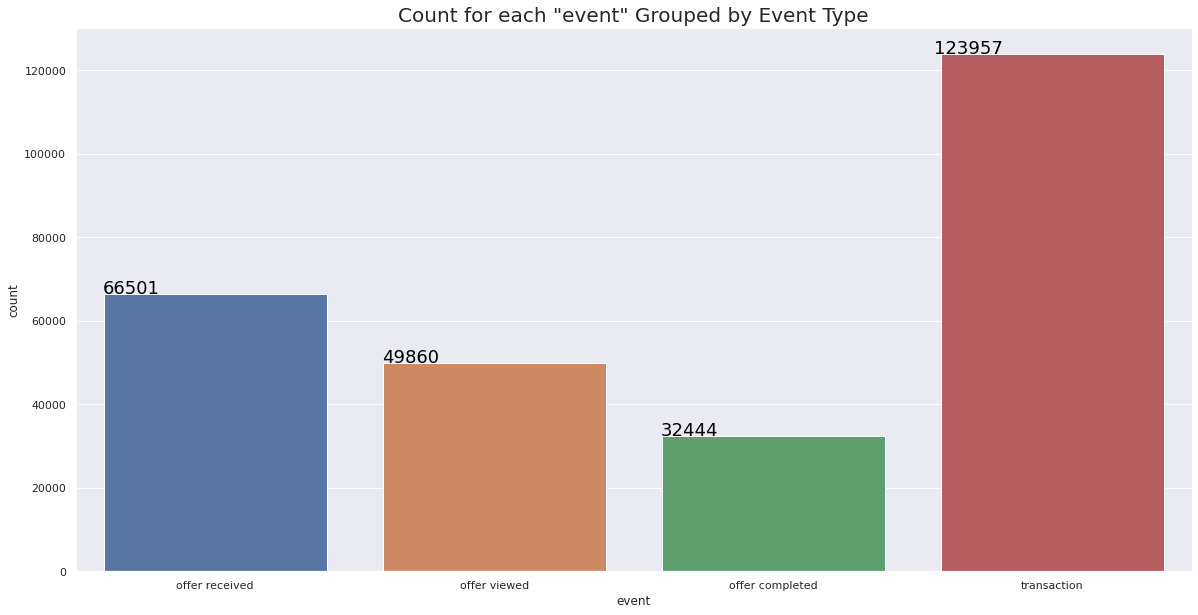

In [84]:
#display chart of count of each event grouped by event type
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='event', data=port_prof_trans)
ax.set_title('Count for each "event" Grouped by Event Type', fontsize=20)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50), ha='center',color='black', size=18)

plt.show()

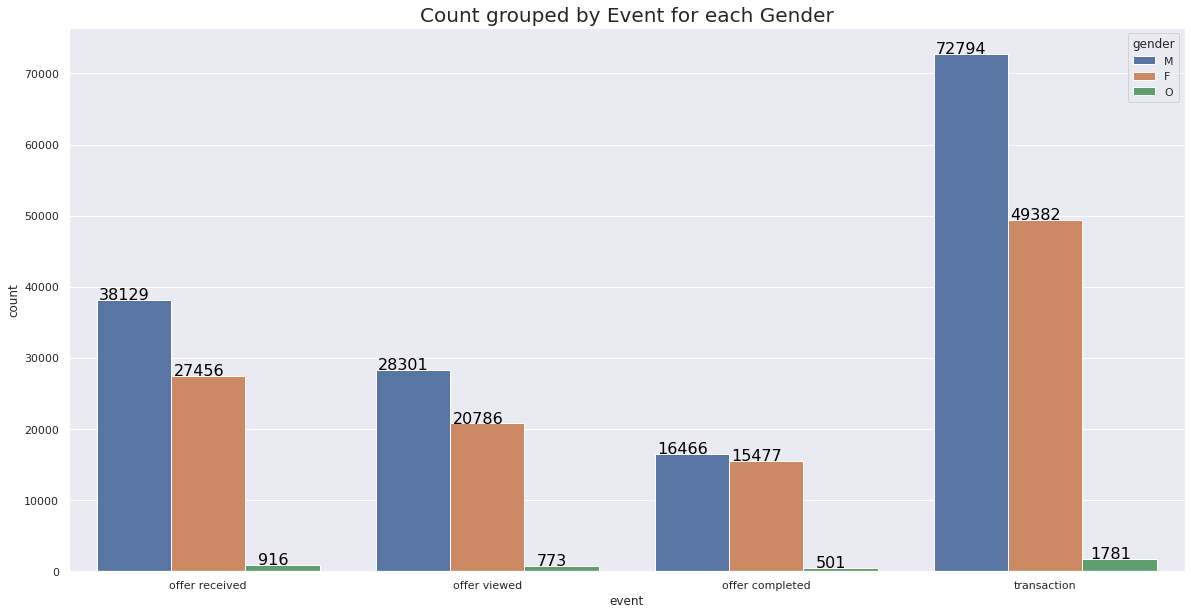

In [85]:
#Display chart for - Count grouped by Event for each Gender

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='event', hue='gender', data=port_prof_trans, hue_order=['M', 'F', 'O'])
ax.set_title('Count grouped by Event for each Gender', fontsize=20)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50), ha='center',color='black', size=16)

plt.show()

I will now be creating two dataframes that will provide count of offer recieved and offer viewed by each of the customers 

In [86]:
#get the total number of count of offer recieved by each person
# construct of dataframe that has person_id and offer recieved count

port_prof_trans.head()
offer_received_item_count = port_prof_trans[(port_prof_trans['offer_received']==1)].person_id.value_counts()
#convert series into dataframe
df_or = offer_received_item_count.to_frame()

#convert index into a column with header index1
df_or['p_id'] = df_or.index
df_or.rename(columns={'person_id': 'offer_recieved_count'}, inplace=True)
df_or.rename(columns={'p_id': 'person_id'}, inplace=True)
df_or.head()

,offer_recieved_count,person_id
11397ef4dbd94143819baaae093e621a,6,11397ef4dbd94143819baaae093e621a
991321fedc8e4c46abd2a17137af756d,6,991321fedc8e4c46abd2a17137af756d
014899c751254a62a96ce676eb11ddc2,6,014899c751254a62a96ce676eb11ddc2
5b4113bf2dd14ca6b4219cea5984e812,6,5b4113bf2dd14ca6b4219cea5984e812
053de26a38684d628b83fef38eae0c69,6,053de26a38684d628b83fef38eae0c69


In [87]:
df_or.offer_recieved_count.unique()

array([6, 5, 4, 3, 2, 1])

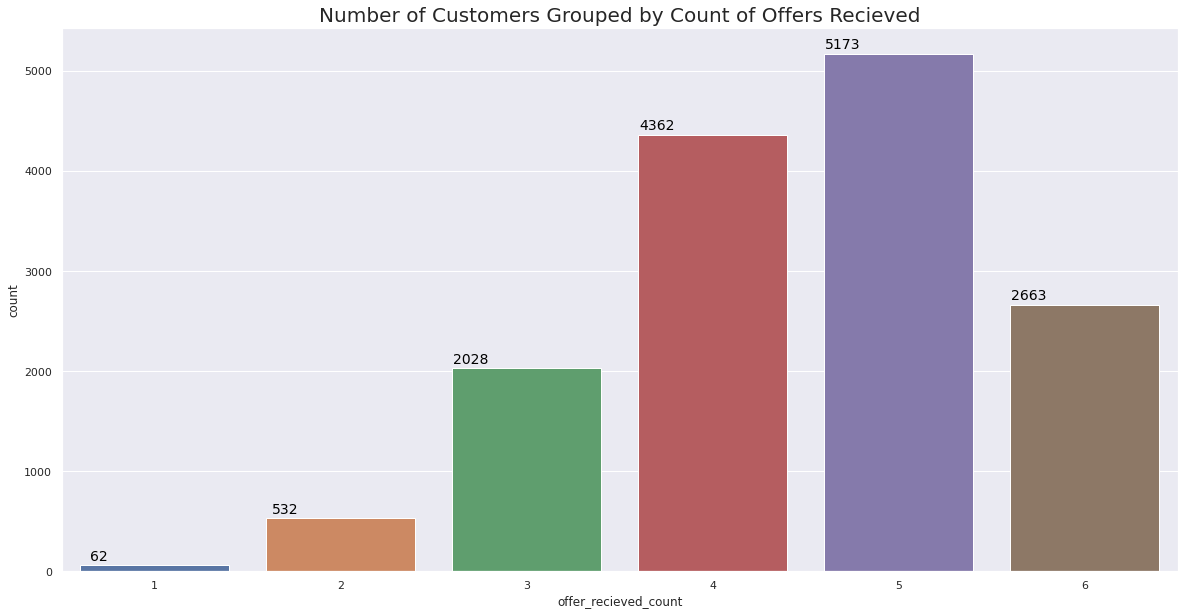

In [88]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='offer_recieved_count', data=df_or)
ax.set_title('Number of Customers Grouped by Count of Offers Recieved', fontsize=20)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50), ha='center',color='black', size=14)

plt.show()

In [89]:
df_or.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14820 entries, 11397ef4dbd94143819baaae093e621a to 7366bef4c288476dab78b09a33d0e692
Data columns (total 2 columns):
offer_recieved_count    14820 non-null int64
person_id               14820 non-null object
dtypes: int64(1), object(1)
memory usage: 987.3+ KB


In [90]:
#get the total number of count of offer viewed by each person
# construct of dataframe that has person_id and offer viewed count

offer_viewed_item_count = port_prof_trans[(port_prof_trans['offer_viewed']==1)].person_id.value_counts()
#convert series into dataframe
df_ov = offer_viewed_item_count.to_frame()

#convert index into a column with header index1
df_ov['p_id'] = df_ov.index
df_ov.rename(columns={'person_id': 'offer_viewed_count'}, inplace=True)
df_ov.rename(columns={'p_id': 'person_id'}, inplace=True)
df_ov.head()

,offer_viewed_count,person_id
f63428edea1e408bb92692e7f02f4e02,6,f63428edea1e408bb92692e7f02f4e02
e1c8fa2cb9184b4999b84f9aea10af6f,6,e1c8fa2cb9184b4999b84f9aea10af6f
d9fe5747442946ce86bb5f0c03bf1e2b,6,d9fe5747442946ce86bb5f0c03bf1e2b
8912f2b9af0c488fb2045d7ca5f5dfb9,6,8912f2b9af0c488fb2045d7ca5f5dfb9
1f72aa042368414d90fb3de6801238ac,6,1f72aa042368414d90fb3de6801238ac


In [91]:
# merge offer rec and offer viewed
df_or_ov = pd.merge(df_ov, df_or, on='person_id', how='outer')
df_or_ov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 3 columns):
offer_viewed_count      14675 non-null float64
person_id               14820 non-null object
offer_recieved_count    14820 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 463.1+ KB


In [92]:
df_or_ov.sort_values('offer_viewed_count').head()

,offer_viewed_count,person_id,offer_recieved_count
14674,1.0,16a48bdaf5834965b67dc0a53cc02721,3
14064,1.0,9289e65861794b46976c13aa27fdf762,4
14063,1.0,c72d471dc4314ffdb062c0775e77a09d,3
14062,1.0,3e1bceba9b6e4dd2964bc101a58baec9,3
14061,1.0,85c02c202b7548e096b4a742368b7e5e,5


In [93]:
#replace NaN values for both recieved and viewed to 0

df_or_ov['offer_viewed_count'] = df_or_ov['offer_viewed_count'].replace(np.nan, 0)
df_or_ov['offer_recieved_count'] = df_or_ov['offer_recieved_count'].replace(np.nan, 0)
df_or_ov.offer_viewed_count = df_or_ov.offer_viewed_count.astype(int)
df_or_ov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 3 columns):
offer_viewed_count      14820 non-null int64
person_id               14820 non-null object
offer_recieved_count    14820 non-null int64
dtypes: int64(2), object(1)
memory usage: 463.1+ KB


In [94]:
df_or_ov.sort_values('offer_viewed_count').head()

,offer_viewed_count,person_id,offer_recieved_count
14819,0,f126206918334d3ea43168faa612e277,1
14725,0,83c2f8b74eb94d3aa06be3beb1b3a2fd,4
14724,0,edc6d54b289c4638a7e59561c0286036,4
14723,0,89c8755ad5ec49daa18dc0a680532341,4
14722,0,e8b235494f694a00bf8b3f1915eb8039,4


* We now have a dataframe(df_or_ov) that has entries for offer recieved and offer viewed for each customer.
* From the analysis above we can see that customers got offers between 1-6 at different point in time.


### Implementation of algorithm

To organize the data from the merged dataset I have written a function that will loop through all the records in the merged dataset and create one enrty each for each cutomer. Based on the logic in the function I will be able to organize the following information
* Amount spent by person in transactions after first offer received
* Total amount given to a person as reward for offers that were viewed
* Amount spent by person in transactions before first offer received
* Total amount given to a person as reward for offers that were NOT viewed before transaction
* Reward amount associated with each of the BOGO and Discount offer types when offer was viewed before the transaction
* Count of offer viewed before the transactions
* Count when the customer was rewarded without viewing the offer

In [95]:
#v4
def prepare_dataset(port_prof_trans_temp):

    '''
    Takes the combined dataframe of portfolio profile and transaction, processed the data and creates one entry for each  .
    customer. Each row has total amount spent, reward recieved by customer for each BOGO or Discount offer types, 
    count of offer viewed
    
    PARAMETERS:
        port_prof_trans_temp dataframe
        
    RETURNS:
        A new dataframe consisting of:
        ["person_id", "gender", "age", "income", "became_member_on", "person_spent_amount", "user_reward", 
        "user_pre_offer_tran_amount", "avoidable_person_reward", "bogo_10_7_10", "bogo_10_5_10", "bogo_5_7_5", 
        "bogo_5_5_5", "discount_20_10_5", "discount_7_7_3", "discount_10_10_2", "discount_10_7_2", 
        "bogo_10_7_10_cnt", "bogo_10_5_10_cnt", "bogo_5_7_5_cnt", "bogo_5_5_5_cnt", "discount_20_10_5_cnt", 
        "discount_7_7_3_cnt", "discount_10_10_2_cnt", "discount_10_7_2_cnt", "no_vw_bogo_10_7_10_cnt", 
        "no_vw_bogo_10_5_10_cnt", "no_vw_bogo_5_7_5_cnt", "no_vw_bogo_5_5_5_cnt", "no_vw_discount_20_10_5_cnt", 
        "no_vw_discount_7_7_3_cnt", "no_vw_discount_10_10_2_cnt", "no_vw_discount_10_7_2_cnt"]
    '''

    dfms = pd.DataFrame()

    d = {}
    d['person_id'] = {}
    d['person_spent_amount'] = {}        # amount spent by person in transactions after first offer received
    d['user_reward'] = {}                # total amount given to a person as reward for offers that were viewed 
    d['user_pre_offer_tran_amount'] = {} # amount spent by person in transactions before first offer received
    d['avoidable_person_reward'] = {}    # total amount given to a person as reward for offers that were NOT viewed before transaction or viewed afterwards

    #reward amount associated with offer type
    d['bogo_10_7_10'] = {}     
    d['bogo_10_5_10'] = {}      
    d['bogo_5_7_5'] = {}        
    d['bogo_5_5_5'] = {}       
    d['discount_20_10_5'] = {} 
    d['discount_7_7_3'] = {}    
    d['discount_10_10_2'] = {}  
    d['discount_10_7_2'] = {}  

    #count associated with offer type when customer viewed the offer before transaction
    d['bogo_10_7_10_cnt'] = {}     
    d['bogo_10_5_10_cnt'] = {}     
    d['bogo_5_7_5_cnt'] = {}       
    d['bogo_5_5_5_cnt'] = {}       
    d['discount_20_10_5_cnt'] = {} 
    d['discount_7_7_3_cnt'] = {}   
    d['discount_10_10_2_cnt'] = {}  
    d['discount_10_7_2_cnt'] = {}  

    #count associated with offer type when customer did not view the offer before transaction
    d['no_vw_bogo_10_7_10_cnt'] = {} 
    d['no_vw_bogo_10_5_10_cnt'] = {}
    d['no_vw_bogo_5_7_5_cnt'] = {}
    d['no_vw_bogo_5_5_5_cnt'] = {}
    d['no_vw_discount_20_10_5_cnt'] = {}
    d['no_vw_discount_7_7_3_cnt'] = {}
    d['no_vw_discount_10_10_2_cnt'] = {}
    d['no_vw_discount_10_7_2_cnt'] = {}

    i = 0
    new_person_flag = True
    person_id2 =''
    fst_entry = 'Y'
    person_spent_amount = 0
    pre_offer_tran_amt = 0
    person_reward = 0
    avoidable_person_reward = 0
    tran_flag ='N'
    offer_flag = ''
    offer_type = ''

    bogo_10_7_10 = 0
    bogo_10_5_10 = 0
    bogo_5_7_5 = 0
    bogo_5_5_5 = 0
    discount_20_10_5 = 0
    discount_7_7_3 = 0
    discount_10_10_2 = 0
    discount_10_7_2 = 0

    bogo_10_7_10_cnt = 0
    bogo_10_5_10_cnt = 0
    bogo_5_7_5_cnt = 0
    bogo_5_5_5_cnt = 0
    discount_20_10_5_cnt = 0
    discount_7_7_3_cnt = 0
    discount_10_10_2_cnt = 0
    discount_10_7_2_cnt = 0

    no_vw_bogo_10_7_10_cnt = 0
    no_vw_bogo_10_5_10_cnt = 0
    no_vw_bogo_5_7_5_cnt = 0
    no_vw_bogo_5_5_5_cnt = 0
    no_vw_discount_20_10_5_cnt = 0
    no_vw_discount_7_7_3_cnt = 0
    no_vw_discount_10_10_2_cnt = 0
    no_vw_discount_10_7_2_cnt = 0

    for ind in port_prof_trans_temp.index:
        person_id = port_prof_trans_temp.loc[ind,'person_id']
        amount = port_prof_trans_temp.loc[ind,'amount']

        if person_id == person_id2:

            if port_prof_trans_temp.loc[ind,'event'] == 'offer received':
                offer_flag = 'R'

            if port_prof_trans_temp.loc[ind,'event'] == 'offer viewed':
                offer_flag = 'V'

            if port_prof_trans_temp.loc[ind,'event'] == 'transaction':
                if tran_flag == 'Y':
                    pre_offer_tran_amt = pre_offer_tran_amt + amount
                else:
                    person_spent_amount = person_spent_amount + amount
            else:
                tran_flag = 'N'

            if port_prof_trans_temp.loc[ind,'event'] == 'offer completed':
                reward = port_prof_trans_temp.loc[ind,'reward']
                if offer_flag == 'V':
                    person_reward = person_reward + reward
                    offer_id = port_prof_trans_temp.loc[ind,'offer_id']
                    if offer_id == 'ae264e3637204a6fb9bb56bc8210ddfd':
                        bogo_10_7_10 = bogo_10_7_10 + reward
                        bogo_10_7_10_cnt = bogo_10_7_10_cnt + 1
                    elif offer_id == '4d5c57ea9a6940dd891ad53e9dbe8da0':
                        bogo_10_5_10 = bogo_10_5_10 + reward
                        bogo_10_5_10_cnt = bogo_10_5_10_cnt + 1
                    elif offer_id == '9b98b8c7a33c4b65b9aebfe6a799e6d9':
                        bogo_5_7_5 = bogo_5_7_5 + reward
                        bogo_5_7_5_cnt = bogo_5_7_5_cnt + 1
                    elif offer_id == 'f19421c1d4aa40978ebb69ca19b0e20d':
                        bogo_5_5_5 = bogo_5_5_5 + reward
                        bogo_5_5_5_cnt = bogo_5_5_5_cnt + 1
                    elif offer_id == '0b1e1539f2cc45b7b9fa7c272da2e1d7':
                        discount_20_10_5 = discount_20_10_5 + reward
                        discount_20_10_5_cnt = discount_20_10_5_cnt + 1
                    elif offer_id == '2298d6c36e964ae4a3e7e9706d1fb8c2':
                        discount_7_7_3 = discount_7_7_3 + reward
                        discount_7_7_3_cnt = discount_7_7_3_cnt + 1
                    elif offer_id == 'fafdcd668e3743c1bb461111dcafc2a4':
                        discount_10_10_2 = discount_10_10_2 + reward
                        discount_10_10_2_cnt = discount_10_10_2_cnt + 1
                    elif offer_id == '2906b810c7d4411798c6938adc9daaa5':
                        discount_10_7_2 = discount_10_7_2 + reward
                        discount_10_7_2_cnt = discount_10_7_2_cnt + 1
                elif offer_flag == 'R':
                    avoidable_person_reward = avoidable_person_reward + reward
                    offer_id = port_prof_trans_temp.loc[ind,'offer_id']
                    if offer_id == 'ae264e3637204a6fb9bb56bc8210ddfd':
                        no_vw_bogo_10_7_10_cnt = no_vw_bogo_10_7_10_cnt + 1
                    elif offer_id == '4d5c57ea9a6940dd891ad53e9dbe8da0':
                        no_vw_bogo_10_5_10_cnt = no_vw_bogo_10_5_10_cnt + 1
                    elif offer_id == '9b98b8c7a33c4b65b9aebfe6a799e6d9':
                        no_vw_bogo_5_7_5_cnt = no_vw_bogo_5_7_5_cnt + 1
                    elif offer_id == 'f19421c1d4aa40978ebb69ca19b0e20d':
                        no_vw_bogo_5_5_5_cnt = no_vw_bogo_5_5_5_cnt + 1
                    elif offer_id == '0b1e1539f2cc45b7b9fa7c272da2e1d7':
                        no_vw_discount_20_10_5_cnt = no_vw_discount_20_10_5_cnt + 1
                    elif offer_id == '2298d6c36e964ae4a3e7e9706d1fb8c2':
                        no_vw_discount_7_7_3_cnt = no_vw_discount_7_7_3_cnt + 1
                    elif offer_id == 'fafdcd668e3743c1bb461111dcafc2a4':
                        no_vw_discount_10_10_2_cnt = no_vw_discount_10_10_2_cnt + 1
                    elif offer_id == '2906b810c7d4411798c6938adc9daaa5':
                        no_vw_discount_10_7_2_cnt = no_vw_discount_10_7_2_cnt + 1

        else:
            if fst_entry == 'N':
                d['person_id'][i] = person_id2
                d['person_spent_amount'][i] = person_spent_amount
                d['user_pre_offer_tran_amount'][i] = pre_offer_tran_amt
                d['user_reward'][i] = person_reward
                d['avoidable_person_reward'][i] = avoidable_person_reward

                d['bogo_10_7_10'][i] = bogo_10_7_10
                d['bogo_10_5_10'][i] = bogo_10_5_10
                d['bogo_5_7_5'][i] = bogo_5_7_5
                d['bogo_5_5_5'][i] = bogo_5_5_5
                d['discount_20_10_5'][i] = discount_20_10_5
                d['discount_7_7_3'][i] = discount_7_7_3
                d['discount_10_10_2'][i] = discount_10_10_2
                d['discount_10_7_2'][i] = discount_10_7_2

                d['bogo_10_7_10_cnt'][i] = bogo_10_7_10_cnt
                d['bogo_10_5_10_cnt'][i] = bogo_10_5_10_cnt
                d['bogo_5_7_5_cnt'][i] = bogo_5_7_5_cnt
                d['bogo_5_5_5_cnt'][i] = bogo_5_5_5_cnt
                d['discount_20_10_5_cnt'][i] = discount_20_10_5_cnt
                d['discount_7_7_3_cnt'][i] = discount_7_7_3_cnt
                d['discount_10_10_2_cnt'][i] = discount_10_10_2_cnt
                d['discount_10_7_2_cnt'][i] = discount_10_7_2_cnt

                d['no_vw_bogo_10_7_10_cnt'][i] = no_vw_bogo_10_7_10_cnt
                d['no_vw_bogo_10_5_10_cnt'][i] = no_vw_bogo_10_5_10_cnt
                d['no_vw_bogo_5_7_5_cnt'][i] = no_vw_bogo_5_7_5_cnt
                d['no_vw_bogo_5_5_5_cnt'][i] = no_vw_bogo_5_5_5_cnt
                d['no_vw_discount_20_10_5_cnt'][i] = no_vw_discount_20_10_5_cnt
                d['no_vw_discount_7_7_3_cnt'][i] = no_vw_discount_7_7_3_cnt
                d['no_vw_discount_10_10_2_cnt'][i] = no_vw_discount_10_10_2_cnt
                d['no_vw_discount_10_7_2_cnt'][i] = no_vw_discount_10_7_2_cnt

                i = i + 1

                person_spent_amount = 0
                person_reward = 0
                avoidable_person_reward = 0
                pre_offer_tran_amt = 0

                bogo_10_7_10 = 0
                bogo_10_5_10 = 0
                bogo_5_7_5 = 0
                bogo_5_5_5 = 0
                discount_20_10_5 = 0
                discount_7_7_3 = 0
                discount_10_10_2 = 0
                discount_10_7_2 = 0

                bogo_10_7_10_cnt = 0
                bogo_10_5_10_cnt = 0
                bogo_5_7_5_cnt = 0
                bogo_5_5_5_cnt = 0
                discount_20_10_5_cnt = 0
                discount_7_7_3_cnt = 0
                discount_10_10_2_cnt = 0
                discount_10_7_2_cnt = 0

                no_vw_bogo_10_7_10_cnt = 0
                no_vw_bogo_10_5_10_cnt = 0
                no_vw_bogo_5_7_5_cnt = 0
                no_vw_bogo_5_5_5_cnt = 0
                no_vw_discount_20_10_5_cnt = 0
                no_vw_discount_7_7_3_cnt = 0
                no_vw_discount_10_10_2_cnt = 0
                no_vw_discount_10_7_2_cnt = 0

            if port_prof_trans_temp.loc[ind,'event'] == 'offer received':
                offer_flag = 'R'

            if port_prof_trans_temp.loc[ind,'event'] == 'transaction':
                pre_offer_tran_amt = pre_offer_tran_amt + amount
                tran_flag = 'Y'

            person_id2 = person_id

            if fst_entry == 'Y':
                fst_entry = 'N'

    d['person_id'][i] = person_id2
    d['person_spent_amount'][i] = person_spent_amount
    d['user_pre_offer_tran_amount'][i] = pre_offer_tran_amt
    d['user_reward'][i] = person_reward
    d['avoidable_person_reward'][i] = avoidable_person_reward

    d['bogo_10_7_10'][i] = bogo_10_7_10
    d['bogo_10_5_10'][i] = bogo_10_5_10
    d['bogo_5_7_5'][i] = bogo_5_7_5
    d['bogo_5_5_5'][i] = bogo_5_5_5
    d['discount_20_10_5'][i] = discount_20_10_5
    d['discount_7_7_3'][i] = discount_7_7_3
    d['discount_10_10_2'][i] = discount_10_10_2
    d['discount_10_7_2'][i] = discount_10_7_2

    d['bogo_10_7_10_cnt'][i] = bogo_10_7_10_cnt
    d['bogo_10_5_10_cnt'][i] = bogo_10_5_10_cnt
    d['bogo_5_7_5_cnt'][i] = bogo_5_7_5_cnt
    d['bogo_5_5_5_cnt'][i] = bogo_5_5_5_cnt
    d['discount_20_10_5_cnt'][i] = discount_20_10_5_cnt
    d['discount_7_7_3_cnt'][i] = discount_7_7_3_cnt
    d['discount_10_10_2_cnt'][i] = discount_10_10_2_cnt
    d['discount_10_7_2_cnt'][i] = discount_10_7_2_cnt

    d['no_vw_bogo_10_7_10_cnt'][i] = no_vw_bogo_10_7_10_cnt
    d['no_vw_bogo_10_5_10_cnt'][i] = no_vw_bogo_10_5_10_cnt
    d['no_vw_bogo_5_7_5_cnt'][i] = no_vw_bogo_5_7_5_cnt
    d['no_vw_bogo_5_5_5_cnt'][i] = no_vw_bogo_5_5_5_cnt
    d['no_vw_discount_20_10_5_cnt'][i] = no_vw_discount_20_10_5_cnt
    d['no_vw_discount_7_7_3_cnt'][i] = no_vw_discount_7_7_3_cnt
    d['no_vw_discount_10_10_2_cnt'][i] = no_vw_discount_10_10_2_cnt
    d['no_vw_discount_10_7_2_cnt'][i] = no_vw_discount_10_7_2_cnt

    dfms=dfms.from_dict(d)

    return dfms
    


In [96]:
# sort port_prof_trans for each person id and then by transcript index to prepare a new dataframe
port_prof_trans_temp = port_prof_trans.sort_values(['person_id', 'transcript_index'], ascending=[True, True])

In [97]:
port_prof_trans_temp.head()

,event,person_id,time,event_datetime,transcript_index,offer_completed,offer_received,offer_viewed,transaction,amount,...,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,offer_reward,offertype
149819,offer received,0009655768c64bdeb2e877511632db8f,168,2018-08-08 00:00:00,55972,0,1,0,0,NaN,...,33.0,2017-04-21,M,72000.0,"[email, mobile, social]",0.0,3.0,informational,0.0,info_0_3_0
149820,offer viewed,0009655768c64bdeb2e877511632db8f,192,2018-08-09 00:00:00,77705,0,0,1,0,NaN,...,33.0,2017-04-21,M,72000.0,"[email, mobile, social]",0.0,3.0,informational,0.0,info_0_3_0
129719,transaction,0009655768c64bdeb2e877511632db8f,228,2018-08-10 12:00:00,89291,0,0,0,1,22.16,...,33.0,2017-04-21,M,72000.0,NaN,NaN,NaN,NaN,NaN,NaN
207391,offer received,0009655768c64bdeb2e877511632db8f,336,2018-08-15 00:00:00,113605,0,1,0,0,NaN,...,33.0,2017-04-21,M,72000.0,"[web, email, mobile]",0.0,4.0,informational,0.0,info_0_4_0
207392,offer viewed,0009655768c64bdeb2e877511632db8f,372,2018-08-16 12:00:00,139992,0,0,1,0,NaN,...,33.0,2017-04-21,M,72000.0,"[web, email, mobile]",0.0,4.0,informational,0.0,info_0_4_0


In [98]:
port_prof_trans_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 149819 to 24751
Data columns (total 22 columns):
event               272762 non-null object
person_id           272762 non-null object
time                272762 non-null int64
event_datetime      272762 non-null datetime64[ns]
transcript_index    272762 non-null int64
offer_completed     272762 non-null uint8
offer_received      272762 non-null uint8
offer_viewed        272762 non-null uint8
transaction         272762 non-null uint8
amount              123957 non-null float64
reward              32444 non-null float64
offer_id            148805 non-null object
age                 272762 non-null float64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
channels            148805 non-null object
difficulty          148805 non-null float64
duration            148805 non-null float64
offer_type          148805 non-null object
offer_rewa

In [99]:
#call function
dfms = prepare_dataset(port_prof_trans_temp)
dfms.head()

,person_id,person_spent_amount,user_reward,user_pre_offer_tran_amount,avoidable_person_reward,bogo_10_7_10,bogo_10_5_10,bogo_5_7_5,bogo_5_5_5,discount_20_10_5,...,discount_10_10_2_cnt,discount_10_7_2_cnt,no_vw_bogo_10_7_10_cnt,no_vw_bogo_10_5_10_cnt,no_vw_bogo_5_7_5_cnt,no_vw_bogo_5_5_5_cnt,no_vw_discount_20_10_5_cnt,no_vw_discount_7_7_3_cnt,no_vw_discount_10_10_2_cnt,no_vw_discount_10_7_2_cnt
0,0009655768c64bdeb2e877511632db8f,127.60,0.0,0.00,9.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,13.0,0.00,0.0,0.0,0.0,5.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,0020c2b971eb4e9188eac86d93036a77,196.86,2.0,0.00,12.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,137.78,13.0,16.27,0.0,0.0,0.0,5.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,48.34,2.0,0.00,7.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0


Merge the two dataframes (dfms and df_or_ov) to get offer recieved count and offer view count for each of the customers added to each record in the df_or_ov dataframe.

In [100]:
#merge the two dataframes to get offer recieved count and offer view count for each of the customers
dfms_or_ov = pd.merge(dfms, df_or_ov, on='person_id', how='outer')
#update the dataframe NaN values to 0 for offer recieved count and offer view count
dfms_or_ov['offer_recieved_count'] = dfms_or_ov['offer_recieved_count'].replace(np.nan, 0)
dfms_or_ov['offer_viewed_count'] = dfms_or_ov['offer_viewed_count'].replace(np.nan, 0)

In [101]:
#create a copy of profile to get gender, age, income and became member on for each customer
profile_temp = profile[['person_id', 'gender', 'age', 'income', 'became_member_on']].copy()
#merge the two dataframes
dfms_or_ov2 = pd.merge(profile_temp, dfms_or_ov, on='person_id', how='outer')

In [102]:
dfms_or_ov2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 35 columns):
person_id                     14825 non-null object
gender                        14825 non-null object
age                           14825 non-null int64
income                        14825 non-null float64
became_member_on              14825 non-null datetime64[ns]
person_spent_amount           14825 non-null float64
user_reward                   14825 non-null float64
user_pre_offer_tran_amount    14825 non-null float64
avoidable_person_reward       14825 non-null float64
bogo_10_7_10                  14825 non-null float64
bogo_10_5_10                  14825 non-null float64
bogo_5_7_5                    14825 non-null float64
bogo_5_5_5                    14825 non-null float64
discount_20_10_5              14825 non-null float64
discount_7_7_3                14825 non-null float64
discount_10_10_2              14825 non-null float64
discount_10_7_2               14825 non-

In [103]:
#since we have count for views that were opened before the transaction for wach of the offer type, we can add those and get a
#consolidated view count for each of the customer
dfms_or_ov2['real_view_count'] = dfms_or_ov2['bogo_10_7_10_cnt'] +  dfms_or_ov2['bogo_10_5_10_cnt'] + dfms_or_ov2['bogo_5_7_5_cnt'] +  dfms_or_ov2['bogo_5_5_5_cnt'] +  dfms_or_ov2['discount_20_10_5_cnt'] +  dfms_or_ov2['discount_7_7_3_cnt'] + dfms_or_ov2['discount_10_10_2_cnt'] +  dfms_or_ov2['discount_10_7_2_cnt']
dfms_or_ov2['no_view_count'] = dfms_or_ov2['no_vw_bogo_10_7_10_cnt'] +  dfms_or_ov2['no_vw_bogo_10_5_10_cnt'] +  dfms_or_ov2['no_vw_bogo_5_7_5_cnt'] +  dfms_or_ov2['no_vw_bogo_5_5_5_cnt'] +  dfms_or_ov2['no_vw_discount_20_10_5_cnt'] +  dfms_or_ov2['no_vw_discount_7_7_3_cnt'] +  dfms_or_ov2['no_vw_discount_10_10_2_cnt'] +  dfms_or_ov2['no_vw_discount_10_7_2_cnt']

dfms_or_ov2.head()


,person_id,gender,age,income,became_member_on,person_spent_amount,user_reward,user_pre_offer_tran_amount,avoidable_person_reward,bogo_10_7_10,...,no_vw_bogo_5_7_5_cnt,no_vw_bogo_5_5_5_cnt,no_vw_discount_20_10_5_cnt,no_vw_discount_7_7_3_cnt,no_vw_discount_10_10_2_cnt,no_vw_discount_10_7_2_cnt,offer_viewed_count,offer_recieved_count,real_view_count,no_view_count
0,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,2017-07-15,23.22,0.0,53.79,5.0,0.0,...,1,0,0,0,0,0,0.0,2.0,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,159.27,5.0,0.00,15.0,0.0,...,0,1,0,0,0,0,4.0,4.0,1,2
2,e2127556f4f64592b11af22de27a7932,M,68,70000.0,2018-04-26,57.73,7.0,0.00,0.0,0.0,...,0,0,0,0,0,0,3.0,4.0,2,0
3,389bc3fa690240e798340f5a15918d5c,M,65,53000.0,2018-02-09,36.43,19.0,0.00,0.0,0.0,...,0,0,0,0,0,0,6.0,6.0,5,0
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,2017-11-11,15.62,2.0,0.00,0.0,0.0,...,0,0,0,0,0,0,2.0,3.0,1,0


In [104]:
sum_column = dfms_or_ov2.sum(axis=0)
print(sum_column)

person_id                     0610b486422d4921ae7d2bf64640c50b78afa995795e4d...
gender                        FFMMMFMFMMFFMFMFFFMMOMFMFMFMFMMFFMFFFFFMFMMMMM...
age                                                                      806384
income                                                              9.69629e+08
person_spent_amount                                                 1.67687e+06
user_reward                                                              111344
user_pre_offer_tran_amount                                                58074
avoidable_person_reward                                                   49197
bogo_10_7_10                                                              24930
bogo_10_5_10                                                              26330
bogo_5_7_5                                                                10660
bogo_5_5_5                                                                16245
discount_20_10_5                        

### Question: What was the total amount that Starbucks gave as discount to customer who did not view the offer but spent enough money to recieve the reward?

In [105]:
print('Total amount that Starbucks gave as discount for customer who did not view the offer but spent enough money to recieve the reward: ' + str(dfms_or_ov2.avoidable_person_reward.sum()))
print('')

Total amount that Starbucks gave as discount for customer who did not view the offer but spent enough money to recieve the reward: 49197.0



#### Based on age demographic what is the count of "offer recieved count" by each of the age groups

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
age                     459 non-null int64
offer_recieved_count    459 non-null float64
counts                  459 non-null int64
dtypes: float64(1), int64(2)
memory usage: 10.8 KB


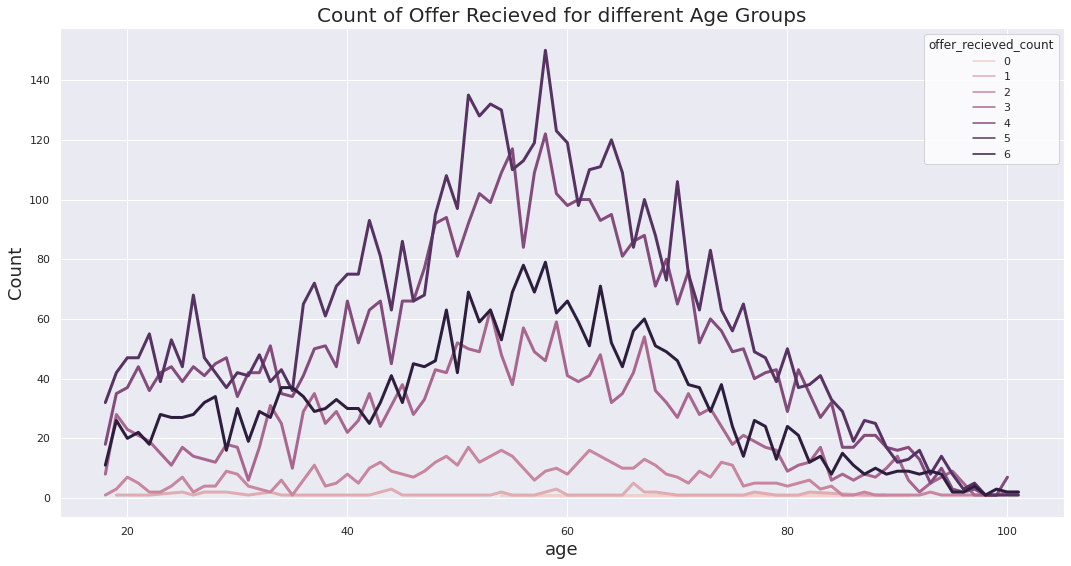

In [106]:
#distribution of count of offer recieved by various age groups
df_age_offer_rec = dfms_or_ov2[['age', 'offer_recieved_count']].copy()
df_age_offer_rec = df_age_offer_rec.groupby(['age', 'offer_recieved_count']).size().reset_index(name='counts')
df_age_offer_rec.info()

dims = (18, 9)
fig, ax = plt.subplots(figsize=dims)
ax.set_title('Count of Offer Recieved for different Age Groups', fontsize=20)
ax.set_xlabel('age', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.set_theme(style="ticks")
sns.lineplot(ax=ax, data=df_age_offer_rec, x="age", y="counts", hue="offer_recieved_count", linewidth = 3, legend="auto");

I re-executed the code below to give a comparison of count of "offer recieved count" and age distibution and it pretty consitant with the age distibution count of profile dataset. 1 and 2 "offer recieved count" seem to be relatively flat across the entire age apectrum but other(3,4,5,6) seem to follow the age distibution count.


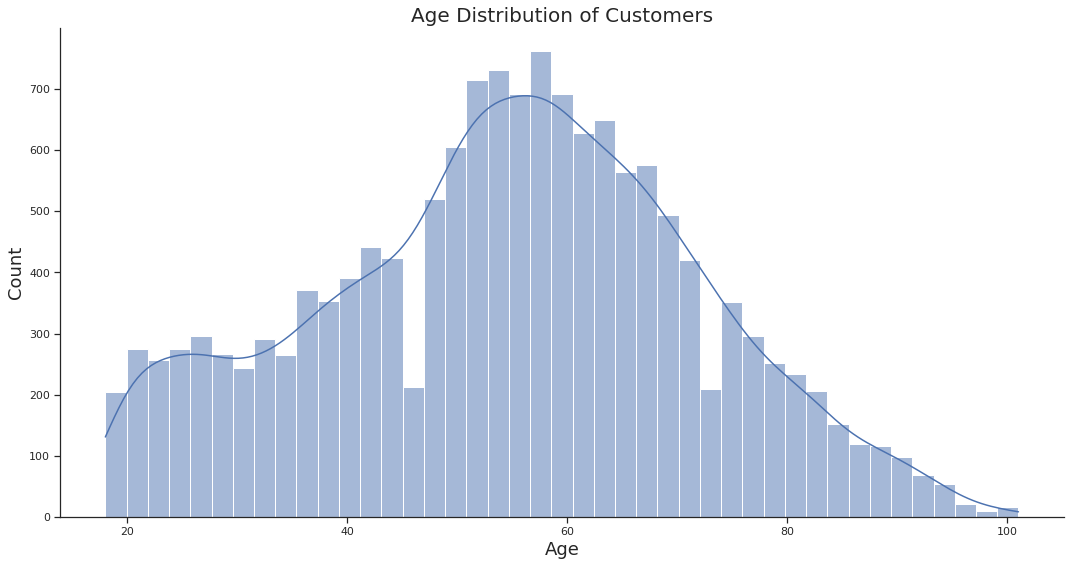

In [107]:
#plot a chart with count distubution for various ages
f, ax = plt.subplots(figsize=(18, 9))
ax.set_title('Age Distribution of Customers', fontsize=20)
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.despine(f)
sns.histplot(data=profile, x="age", kde=True);

#### Based on income demographic what is the count of "offer recieved count" by each of the income groups

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 3 columns):
income                  496 non-null float64
offer_recieved_count    496 non-null float64
counts                  496 non-null int64
dtypes: float64(2), int64(1)
memory usage: 11.7 KB


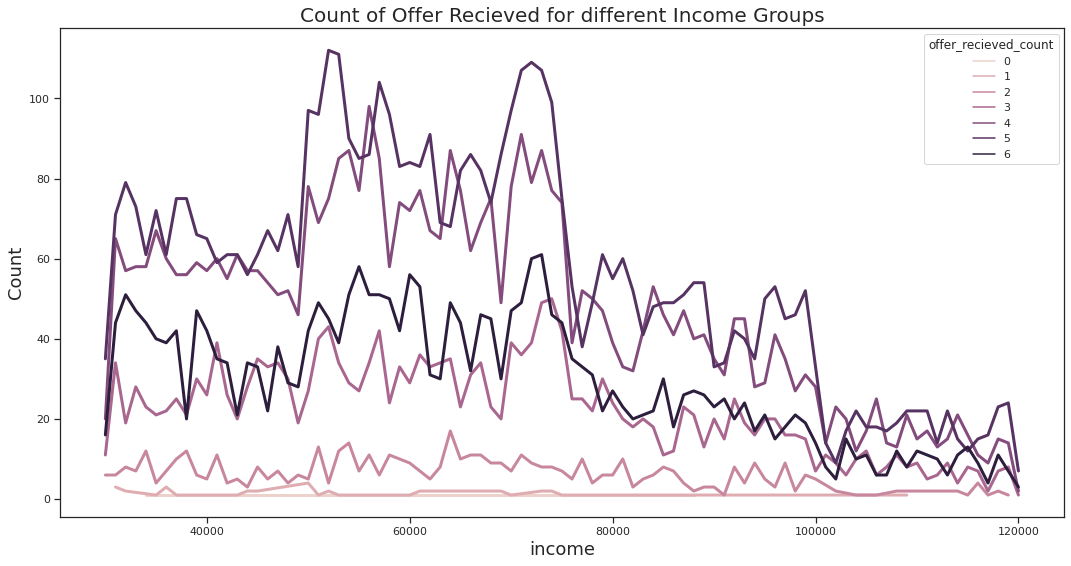

In [108]:
#distribution of count of offer recieved by various income groups
df_income_offer_rec = dfms_or_ov2[['income', 'offer_recieved_count']].copy()
df_income_offer_rec = df_income_offer_rec.groupby(['income', 'offer_recieved_count']).size().reset_index(name='counts')
df_income_offer_rec.info()

dims = (18, 9)
fig, ax = plt.subplots(figsize=dims)
ax.set_title('Count of Offer Recieved for different Income Groups', fontsize=20)
ax.set_xlabel('income', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.set_theme(style="ticks")
sns.lineplot(ax=ax, data=df_income_offer_rec, x="income", y="counts", hue="offer_recieved_count", linewidth = 3, legend="auto");

I re-executed the code below to give a comparison of count of "offer recieved count" and age distibution and it pretty consitant with the income distibution count of profile dataset. 

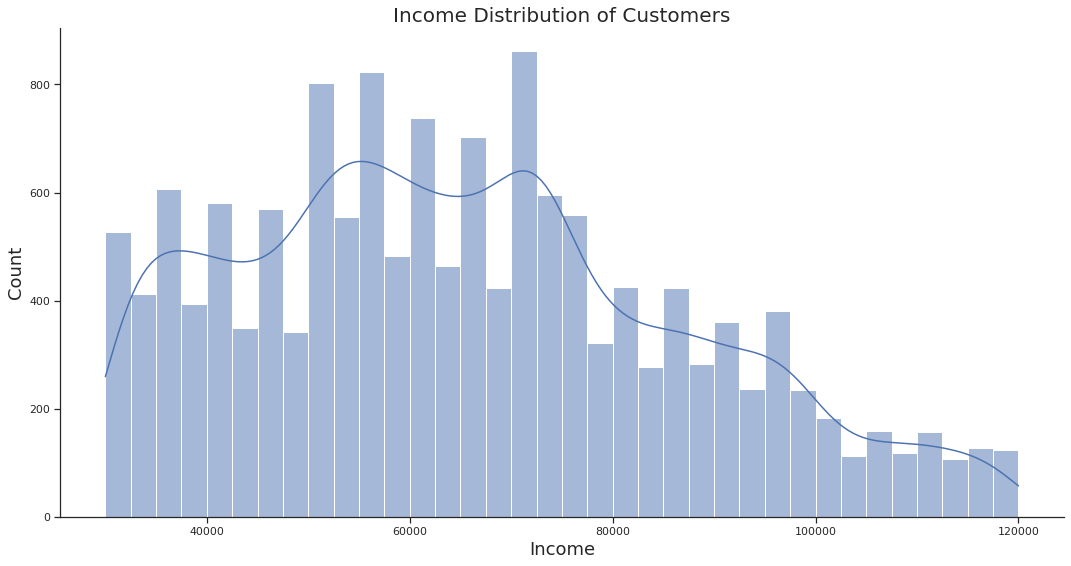

In [109]:
#plot a chart with count distubution for various income
f, ax = plt.subplots(figsize=(18, 9))
ax.set_title('Income Distribution of Customers', fontsize=20)
ax.set_xlabel('Income', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
sns.despine(f)
sns.histplot(data=profile, x="income", kde=True);

### Spend per person and weighted mean deviation by age

#### What was the spend per person by each Age category and the deviation of spend for each age category from weighted mean of the total spend in the dataset?

I calculated the weighted mean for spend per person to calculate the deviation from the average spend per person for each of the age categories.

In [110]:
dfms_or_ov2_agg_spend = (dfms_or_ov2.groupby('age')
      .agg({'person_id':'count', 'person_spent_amount': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_agg_spend['spend_per_person'] = dfms_or_ov2_agg_spend['person_spent_amount']/dfms_or_ov2_agg_spend['person_count']

#weighted mean calculation
spend_per_person_w_mean = dfms_or_ov2_agg_spend.person_spent_amount.sum()/dfms_or_ov2_agg_spend.person_count.sum()
dfms_or_ov2_agg_spend['spend_per_person_w_mean_dev'] = dfms_or_ov2_agg_spend['spend_per_person'] - spend_per_person_w_mean

dfms_or_ov2_agg_spend.head()



,age,person_count,person_spent_amount,spend_per_person,spend_per_person_w_mean_dev
0,18,70,5516.94,78.813429,-34.297422
1,19,135,9430.36,69.854519,-43.256332
2,20,135,9934.35,73.587778,-39.523073
3,21,140,13447.97,96.056929,-17.053922
4,22,131,11980.79,91.456412,-21.654438


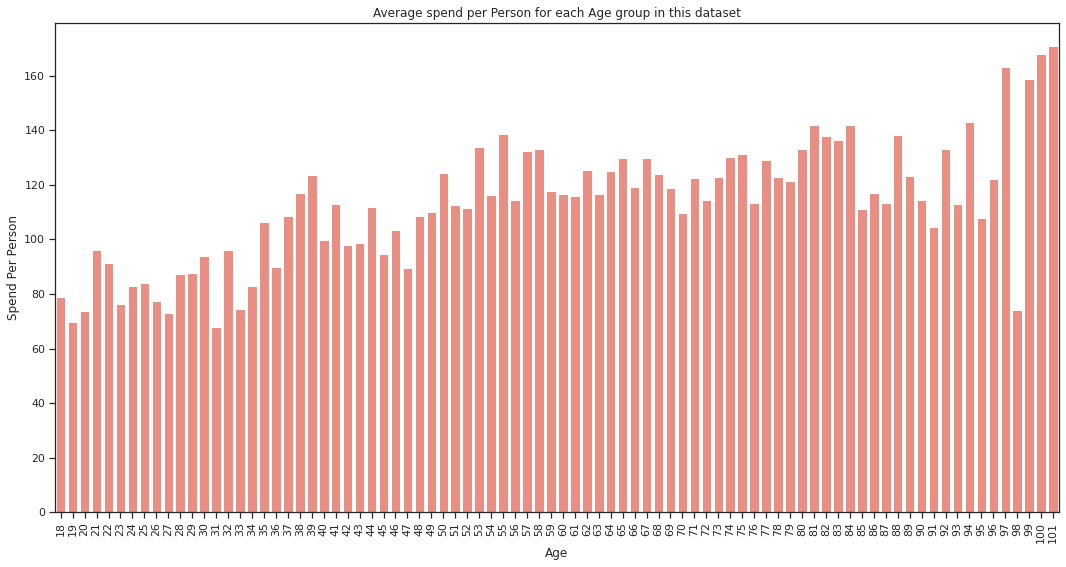

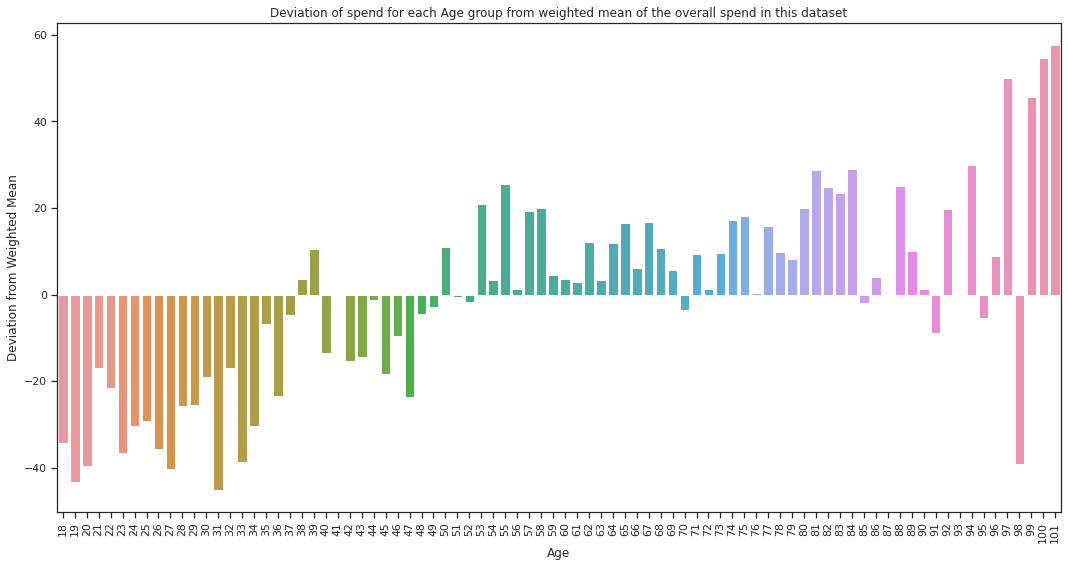

In [111]:
#What was the spend per person by each Age category

f, ax = plt.subplots(figsize = (18,9))
ax = sns.barplot(x=dfms_or_ov2_agg_spend.age, y=dfms_or_ov2_agg_spend.spend_per_person, color="salmon")
ax.set(xlabel='Age', ylabel='Spend Per Person')
ax.set_title('Average spend per Person for each Age group in this dataset')

for item in ax.get_xticklabels():
    item.set_rotation(90)

#what is the deviation of this spend from weighted mean of the overall spend in this dataset

f, ax = plt.subplots(figsize = (18,9))
ax = sns.barplot(x=dfms_or_ov2_agg_spend.age, y=dfms_or_ov2_agg_spend.spend_per_person_w_mean_dev)
ax.set(xlabel='Age', ylabel='Deviation from Weighted Mean')
ax.set_title('Deviation of spend for each Age group from weighted mean of the overall spend in this dataset')

for item in ax.get_xticklabels():
    item.set_rotation(90)


The two chart above display the average spend per person based on age category and the deviation from the weighted mean of the spend. 
* In the first chart the trend seems to be increased spend with the increase in age.
* From the second chart barring few categories it looks like the younger age is lagging the weighted mean while 53+ age is spending more than the weighted mean.

### Spend per person and weighted mean deviation by income

#### What was the spend per person by each income category and the deviation of spend for each income category from weighted mean of the total spend in the dataset?

I calculated the weighted mean for spend per person to calculate the deviation from the average spend per person for each of the income categories.

In [112]:
dfms_or_ov2_agg_spend2 = (dfms_or_ov2.groupby('income')
      .agg({'person_id':'count', 'person_spent_amount': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_agg_spend2['spend_per_person'] = dfms_or_ov2_agg_spend2['person_spent_amount']/dfms_or_ov2_agg_spend2['person_count']

#weighted mean calculation
spend_per_person_w_mean = dfms_or_ov2_agg_spend2.person_spent_amount.sum()/dfms_or_ov2_agg_spend2.person_count.sum()
dfms_or_ov2_agg_spend2['spend_per_person_w_mean_dev'] = dfms_or_ov2_agg_spend2['spend_per_person'] - spend_per_person_w_mean

dfms_or_ov2_agg_spend2.head()

,income,person_count,person_spent_amount,spend_per_person,spend_per_person_w_mean_dev
0,30000.0,88,4109.50,46.698864,-66.411987
1,31000.0,223,13433.12,60.238206,-52.872644
2,32000.0,216,11953.82,55.341759,-57.769091
3,33000.0,213,13228.09,62.103709,-51.007142
4,34000.0,199,12167.22,61.141809,-51.969042


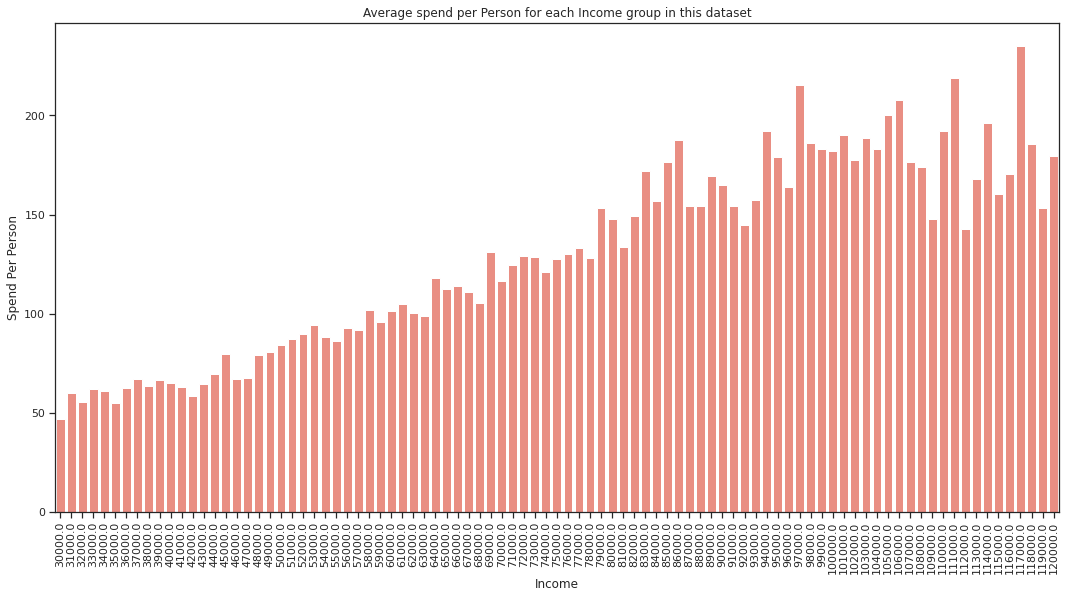

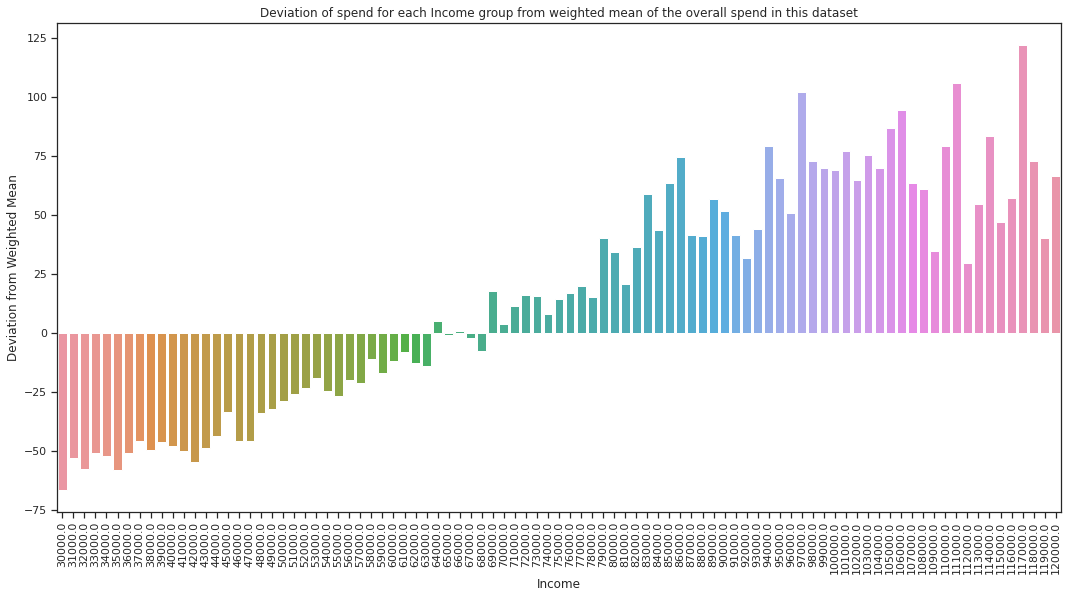

In [113]:
#What was the spend per person by each Income category

f, ax = plt.subplots(figsize = (18,9))
ax = sns.barplot(x=dfms_or_ov2_agg_spend2.income, y=dfms_or_ov2_agg_spend2.spend_per_person, color="salmon")
ax.set(xlabel='Income', ylabel='Spend Per Person')
ax.set_title('Average spend per Person for each Income group in this dataset')

for item in ax.get_xticklabels():
    item.set_rotation(90)

#what is the deviation of this spend from weighted mean of the overall spend in this dataset

f, ax = plt.subplots(figsize = (18,9))
ax = sns.barplot(x=dfms_or_ov2_agg_spend2.income, y=dfms_or_ov2_agg_spend2.spend_per_person_w_mean_dev)
ax.set(xlabel='Income', ylabel='Deviation from Weighted Mean')
ax.set_title('Deviation of spend for each Income group from weighted mean of the overall spend in this dataset')

for item in ax.get_xticklabels():
    item.set_rotation(90)

The two chart above display the average spend per person based on income category and the deviation from the weighted mean of the spend. 
* In the first chart it the trend seems to be increased spend wit the increase in income.
* From the second chart upto 69K is lagging the weighted mean while 70K+ income is spending more than the weighted mean.

### Question : Based on the count of offer viewed which offer in BOGO & DIscount category is the most popular overall?

In [114]:
sum_column = dfms_or_ov2[['bogo_10_7_10_cnt', 'bogo_10_5_10_cnt', 'bogo_5_7_5_cnt', 'bogo_5_5_5_cnt', 
                          'discount_20_10_5_cnt', 'discount_7_7_3_cnt', 'discount_10_10_2_cnt', 
                          'discount_10_7_2_cnt']].sum(axis=0)
dfms_or_ov2_sum_column = sum_column.to_frame().reset_index()
dfms_or_ov2_sum_column.columns = ['offer_type', 'sum_count']
dfms_or_ov2_sum_column['offer_type'] = dfms_or_ov2_sum_column['offer_type'].str.replace('_cnt','')
dfms_or_ov2_sum_column = dfms_or_ov2_sum_column.sort_values(by=['sum_count'], ascending=False)
dfms_or_ov2_sum_column

,offer_type,sum_count
6,discount_10_10_2,4006
5,discount_7_7_3,3921
3,bogo_5_5_5,3249
1,bogo_10_5_10,2633
0,bogo_10_7_10,2493
7,discount_10_7_2,2182
2,bogo_5_7_5,2132
4,discount_20_10_5,1808


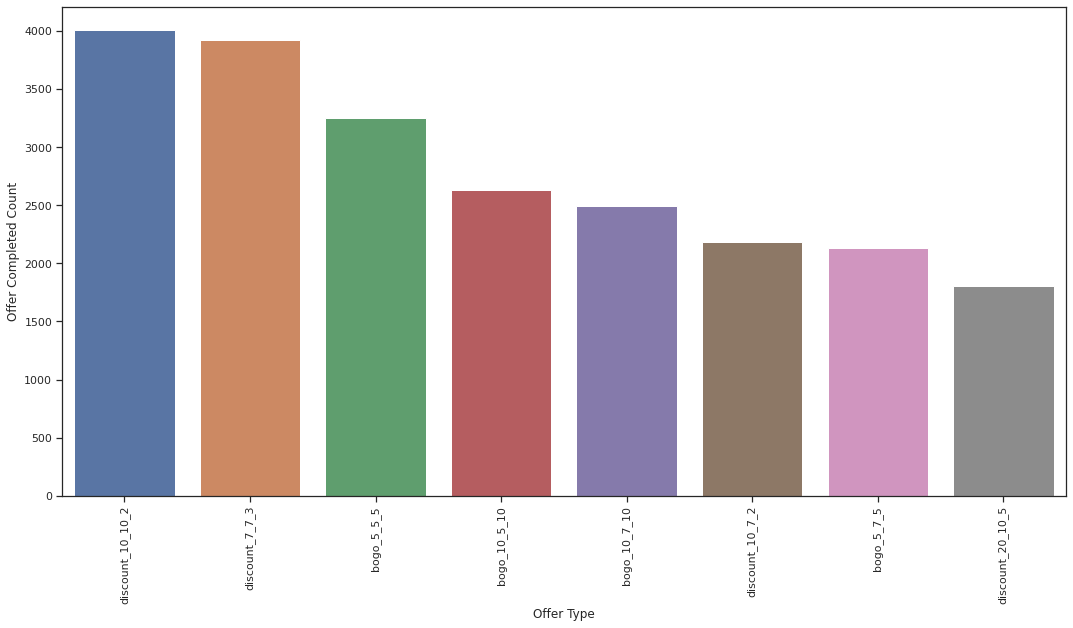

In [115]:
#Display bar chart based on offer view count by all customers

f, ax = plt.subplots(figsize = (18,9))
ax = sns.barplot(x='offer_type', y='sum_count', data=dfms_or_ov2_sum_column, ci=None, estimator=sum)
ax.set(xlabel='Offer Type', ylabel='Offer Completed Count')

for item in ax.get_xticklabels():
    item.set_rotation(90)


In [116]:
print('Based on count of offers viewed by all customer, ' + str(dfms_or_ov2_sum_column['offer_type'].iloc[0]) + ' offer type is the most popular offer overall.')


Based on count of offers viewed by all customer, discount_10_10_2 offer type is the most popular offer overall.


#### As can be seen from the results and chart above Discount_10_10_2 is the most popular offer. The other in the popularity rankings are also listed.

discount_10_10_2 offer is Discount that requires amount 10 to be spent in a period of 10 days with a reward of 2 being given.



### Question: For age and income demographic, where is the opportunity to increase the number of offers sent and increase sales?


* In this part of analysis I will be calculating offer recieved count per person and the real view count per person. I then further calculate the ratio of offer view to offer recieved. In a perfect situation real view count will be same as offer recieved count and the ratio would be 1.0. In the data we are evaluating below this ratio will be less than 1.0. The close the ratio would be to 1.0, the higher the participation would be.  
* From our earlier analysis of data we know that he maximum number of offers that can be recieved by customers is 6.
* The evaluation is based on age categories for all gender and then filtering it futher on M and F gender
* The same analysis is then applied for income categories.

In [117]:
def prepare_agg_rec_view_df(df_agg_rec_view, demo_var, gender):
    
    '''
    Takes a dataframe, demographic value and gender value. Function calculates offer recieved per person, 
    offer viewed per person and the ratio of recieve view. 
    
    PARAMETERS:
        Dataframe, demographic value, gender value
        
    RETURNS:
        A new dataframe with the aggragated values based on the calulation for each demograhic group
    
    '''
    
    if gender != '':
        df_agg_rec_view = df_agg_rec_view.loc[df_agg_rec_view['gender'] == gender]
    
    df_agg_rec_view = (df_agg_rec_view.groupby(demo_var)
          .agg({'person_id':'count', 'offer_recieved_count': 'sum', 'real_view_count': 'sum'})
          .reset_index().rename(columns={'person_id':'person_count'}))

    df_agg_rec_view['offer_rec_per_person'] = df_agg_rec_view['offer_recieved_count']/df_agg_rec_view['person_count']
    df_agg_rec_view['offer_view_per_person'] = df_agg_rec_view['real_view_count']/df_agg_rec_view['person_count']
    df_agg_rec_view['recieve_view_ratio'] = df_agg_rec_view['offer_view_per_person']/df_agg_rec_view['offer_rec_per_person']
    
    return df_agg_rec_view


In [118]:
def plot_agg_rec_view(df_agg_rec_view, demo_var):
    
    '''
    Generates a chart based on the condition provided
    
    PARAMETERS:
        Dataframe and demographic value
    
    RETURNS:
        None    
    
    '''
    
    fig,ax=plt.subplots(figsize = (18,9))

    ax.plot(df_agg_rec_view[demo_var], df_agg_rec_view.offer_rec_per_person, color="red", marker="o")
    ax.set_xlabel(demo_var, fontsize=18)
    ax.set_ylabel("Offer Recieved Per Person", color="red", fontsize=18)

    ax2=ax.twinx()
    ax2.plot(df_agg_rec_view[demo_var], df_agg_rec_view.recieve_view_ratio, color="blue", marker="o")
    ax2.set_ylabel("Offer - Recieve:View Ratio Per Person", color="blue", fontsize=18)

    plt.show()


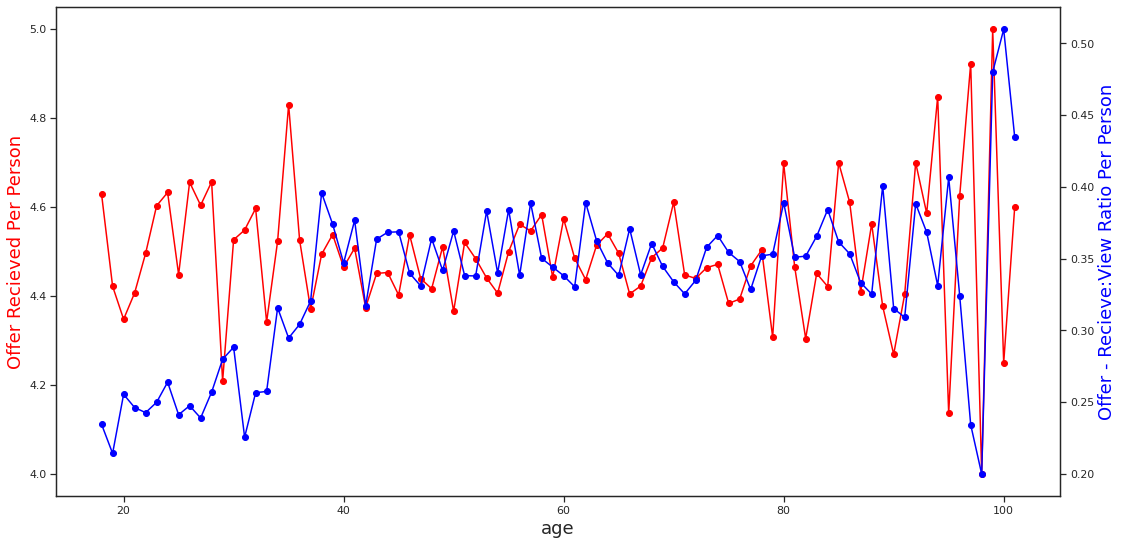

In [119]:
#evaluation on age demographic
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'age','')
plot_agg_rec_view(df_agg_rec_view,'age')

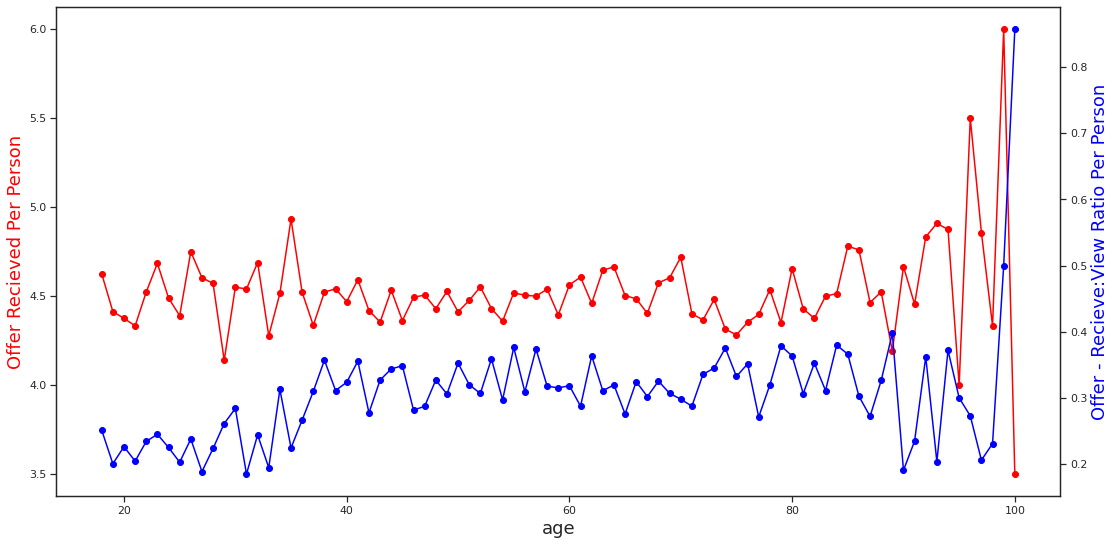

In [120]:
#evaluation on age demographic and gender 'M'
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'age','M')
plot_agg_rec_view(df_agg_rec_view,'age')

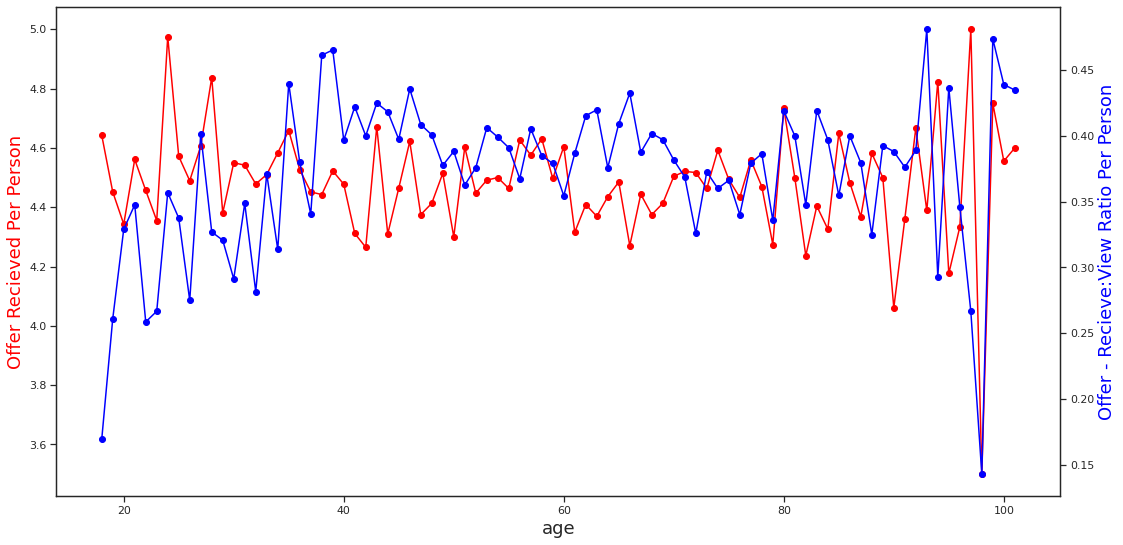

In [121]:
#evaluation on age demographic and gender 'F'
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'age','F')
plot_agg_rec_view(df_agg_rec_view,'age')

* The 3 chart above are evaluated on age category
* First chart is for all genders. Second chart is for gender M and third chart is for gender F.
* In the first chart we can see that the average offer received is 4.5 +/- 0.2. 
* Offer recieve/view ratio is low until age 35 but then increases and stays in the increased range until age 90.
* We have a possibility here where for this age group we can increase the offers possibly by to increase the sales.
* When we look at the second chart the offer recieve/view ratio is lagging the average for the overall gender ratio.
* The third chart shows a higher ratio for age group 35-90. This means that we have better participation for gender F and would have posibility of increasing the sales if this group is targetted.

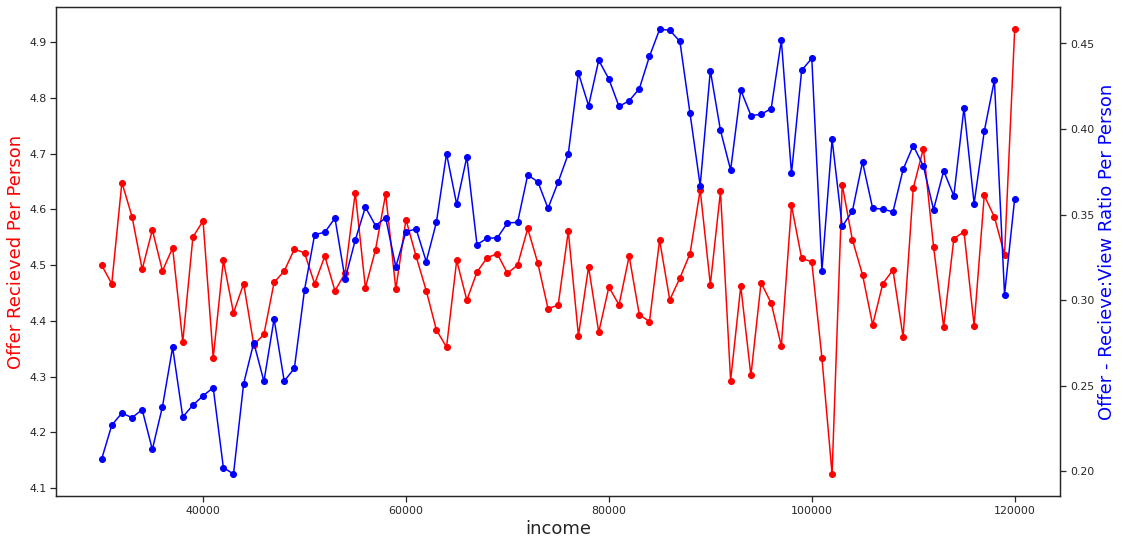

In [122]:
#evaluation on income demographic
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'income','')
plot_agg_rec_view(df_agg_rec_view,'income')

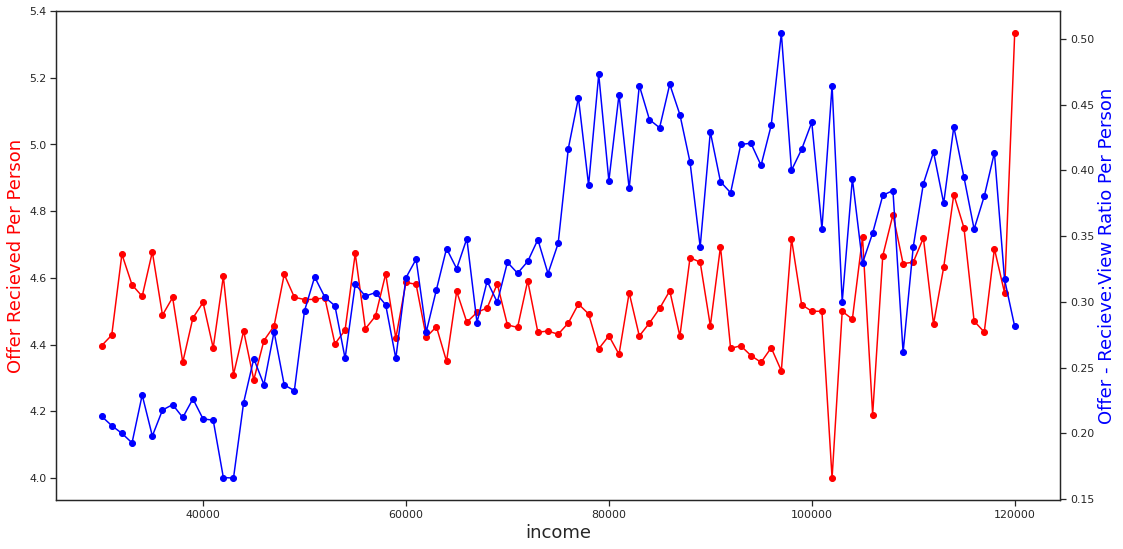

In [123]:
#evaluation on income demographic and gender 'M'
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'income','M')
plot_agg_rec_view(df_agg_rec_view, 'income')

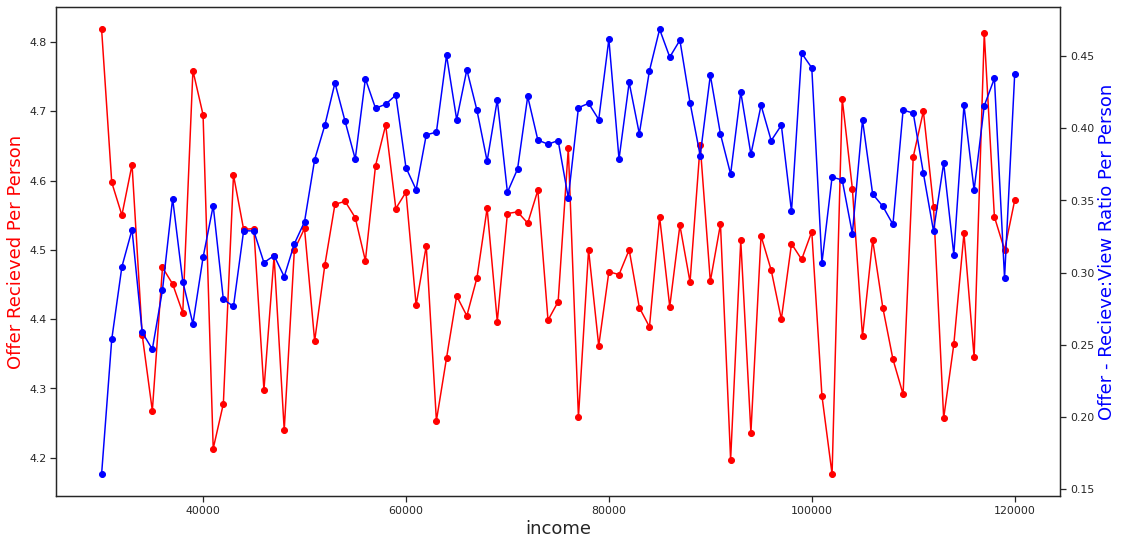

In [124]:
#evaluation on income demographic and gender 'F'
df_agg_rec_view = prepare_agg_rec_view_df(dfms_or_ov2,'income','F')
plot_agg_rec_view(df_agg_rec_view, 'income')

* The 3 chart above are evaluated on income category
* First chart is for all genders. Second chart is for gender M and third chart is for gender F.
* In the chart we can see that the ratio is moving towards the higher side for income groups that are 70K plus. 
* For gender F it starts to increase around 50K mark.
* This along with age information can be combined to further refine the targetted group where we have a higher possibility of increasing sales.

### Question: What is/are the best offer(s) at an individual personalized level - grouped by age category?

In this part of analysis I am going to aggragage the sum of the number of offer completed in each of the categories in BOGO and Discount and divide them by count of individuals in that group to get a per person count. Higher the value of per count for each of the age categories, more popular the offer is.

In [125]:
def prepare_grp_count(df_grp, grp_param):

    '''
    Takes the dataframe and demographic parameter based on which grouping is done and dataframe that has per person 
    offer completed count for each of the demographic groups 
    
    PARAMETERS:
        Dataframe and demographic parameter 
        
    RETURNS:
        A new dataframe consisting of per person offer completed count for each of the demographic group
    '''

    dfms_or_ov2_grp = (df_grp.groupby(grp_param)
          .agg({'person_id':'count', 'bogo_10_7_10_cnt': 'sum', 'bogo_10_5_10_cnt': 'sum', 'bogo_5_7_5_cnt': 'sum', 
                'bogo_5_5_5_cnt': 'sum', 'discount_20_10_5_cnt': 'sum', 'discount_7_7_3_cnt': 'sum', 
                'discount_10_10_2_cnt': 'sum', 'discount_10_7_2_cnt': 'sum'})
          .reset_index().rename(columns={'person_id':'person_count'}))

    dfms_or_ov2_grp['bogo_10_7_10_per_person_cnt'] = dfms_or_ov2_grp['bogo_10_7_10_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['bogo_10_5_10_per_person_cnt'] = dfms_or_ov2_grp['bogo_10_5_10_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['bogo_5_7_5_per_person_cnt'] = dfms_or_ov2_grp['bogo_5_7_5_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['bogo_5_5_5_per_person_cnt'] = dfms_or_ov2_grp['bogo_5_5_5_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['discount_20_10_5_per_person_cnt'] = dfms_or_ov2_grp['discount_20_10_5_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['discount_7_7_3_per_person_cnt'] = dfms_or_ov2_grp['discount_7_7_3_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['discount_10_10_2_per_person_cnt'] = dfms_or_ov2_grp['discount_10_10_2_cnt']/dfms_or_ov2_grp['person_count']
    dfms_or_ov2_grp['discount_10_7_2_per_person_cnt'] = dfms_or_ov2_grp['discount_10_7_2_cnt']/dfms_or_ov2_grp['person_count']


    df_grp_temp = dfms_or_ov2_grp[[grp_param, 'bogo_10_7_10_per_person_cnt', 'bogo_10_5_10_per_person_cnt', 'bogo_5_7_5_per_person_cnt', 
                  'bogo_5_5_5_per_person_cnt', 'discount_20_10_5_per_person_cnt', 'discount_7_7_3_per_person_cnt', 
                  'discount_10_10_2_per_person_cnt', 'discount_10_7_2_per_person_cnt']].copy()

    dfms_or_ov2_grp = df_grp_temp.set_index(grp_param)
    
    return dfms_or_ov2_grp


In [126]:
dfms_or_ov2_grp_age = prepare_grp_count(dfms_or_ov2, 'age')
dfms_or_ov2_grp_age.head()

,bogo_10_7_10_per_person_cnt,bogo_10_5_10_per_person_cnt,bogo_5_7_5_per_person_cnt,bogo_5_5_5_per_person_cnt,discount_20_10_5_per_person_cnt,discount_7_7_3_per_person_cnt,discount_10_10_2_per_person_cnt,discount_10_7_2_per_person_cnt
age,,,,,,,,
18,0.100000,0.042857,0.071429,0.200000,0.114286,0.285714,0.200000,0.071429
19,0.118519,0.111111,0.066667,0.118519,0.074074,0.185185,0.200000,0.074074
20,0.103704,0.140741,0.059259,0.207407,0.066667,0.214815,0.177778,0.140741
21,0.092857,0.100000,0.092857,0.214286,0.064286,0.221429,0.214286,0.085714
22,0.129771,0.068702,0.091603,0.183206,0.061069,0.282443,0.183206,0.091603


For all the age groups acorss the 8 offers being evaluated, I am creating a heat map to provide a visual representation of the popular offers. In the second heat map below I have highest values cell in each row(age category) higlighted with color that represents the highest value.

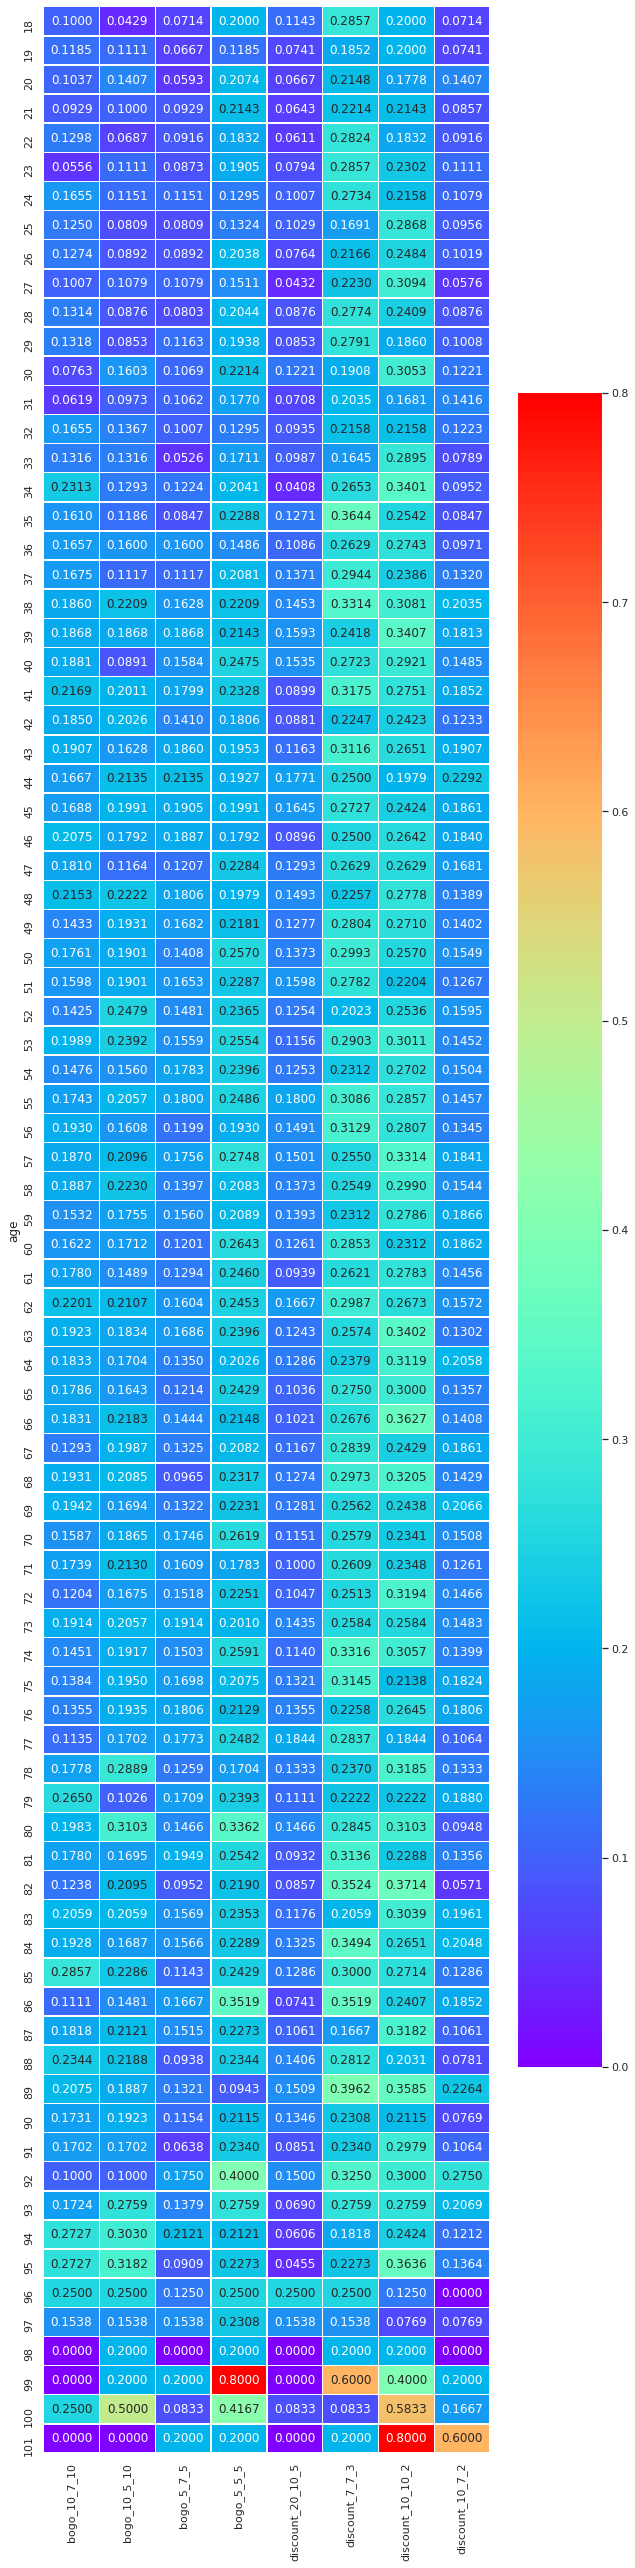

In [127]:
dfms_or_ov2_grp_age.columns = ['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

#create heatmap chart
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 45))
sns.heatmap(dfms_or_ov2_grp_age, annot=True, fmt=".4f", cmap='rainbow', linewidths=.5, ax=ax); 


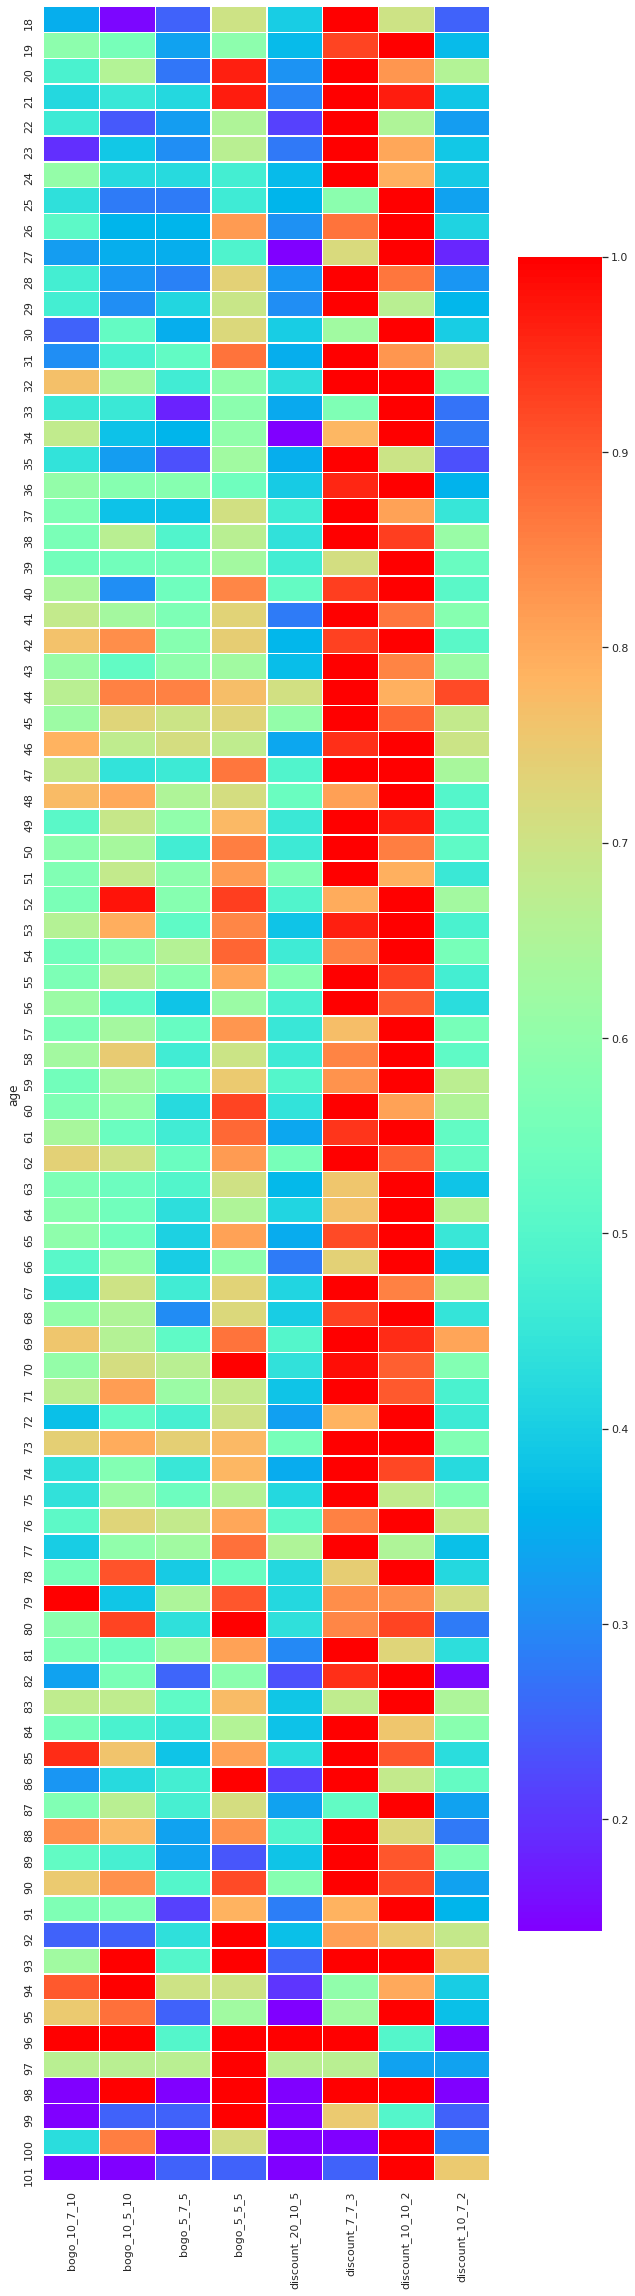

In [128]:
#create heatmap chart identifying most popular offer for each age group
sns.set_theme()
dfms_or_ov2_grp_age_row = dfms_or_ov2_grp_age.div(dfms_or_ov2_grp_age.max(axis=1), axis=0)
f, ax = plt.subplots(figsize=(10, 40))
sns.heatmap(dfms_or_ov2_grp_age_row, linewidths=.5 , cmap='rainbow',robust=True ,annot_kws = {'size':14});
 


### Question: For each of the offers, what are the top 5 age groups that have used it the most(per person average)?

In [129]:
dfms_or_ov2_grp_age = dfms_or_ov2_grp_age.reset_index()
dfms_or_ov2_grp_age.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
age                 84 non-null int64
bogo_10_7_10        84 non-null float64
bogo_10_5_10        84 non-null float64
bogo_5_7_5          84 non-null float64
bogo_5_5_5          84 non-null float64
discount_20_10_5    84 non-null float64
discount_7_7_3      84 non-null float64
discount_10_10_2    84 non-null float64
discount_10_7_2     84 non-null float64
dtypes: float64(8), int64(1)
memory usage: 6.0 KB


In [130]:
print('For each of the offers these are the top 5 age groups that have used it the most (per person average):')
for x in range(1, 9):
    colname = dfms_or_ov2_grp_age.columns[x]
    print('')
    print('--------------Offer type: ' + colname + '-----------------------------------')
    dfms_or_ov2_grp_age = dfms_or_ov2_grp_age.sort_values(by=[dfms_or_ov2_grp_age.columns[x]], ascending=False)
    for y in range(0,5):
        print(str(y+1) + '.  -- ' + str(dfms_or_ov2_grp_age['age'].iloc[y]))


For each of the offers these are the top 5 age groups that have used it the most (per person average):

--------------Offer type: bogo_10_7_10-----------------------------------
1.  -- 85
2.  -- 94
3.  -- 95
4.  -- 79
5.  -- 96

--------------Offer type: bogo_10_5_10-----------------------------------
1.  -- 100
2.  -- 95
3.  -- 80
4.  -- 94
5.  -- 78

--------------Offer type: bogo_5_7_5-----------------------------------
1.  -- 44
2.  -- 94
3.  -- 101
4.  -- 99
5.  -- 81

--------------Offer type: bogo_5_5_5-----------------------------------
1.  -- 99
2.  -- 100
3.  -- 92
4.  -- 86
5.  -- 80

--------------Offer type: discount_20_10_5-----------------------------------
1.  -- 96
2.  -- 77
3.  -- 55
4.  -- 44
5.  -- 62

--------------Offer type: discount_7_7_3-----------------------------------
1.  -- 99
2.  -- 89
3.  -- 35
4.  -- 82
5.  -- 86

--------------Offer type: discount_10_10_2-----------------------------------
1.  -- 101
2.  -- 100
3.  -- 99
4.  -- 82
5.  -- 95

----------

### Question: What is/are the best offer(s) at an individual personalized level - grouped by income category?

In this part of analysis I am going to aggragage the sum of the number of offer completed in each of the categories in BOGO and Discount and divide them by count of individuals in that group to get a per person count. Higer the value of per count for each of the income categories, more popular the offer is.

In [131]:
dfms_or_ov2_grp_income = prepare_grp_count(dfms_or_ov2, 'income')
dfms_or_ov2_grp_income.head()

,bogo_10_7_10_per_person_cnt,bogo_10_5_10_per_person_cnt,bogo_5_7_5_per_person_cnt,bogo_5_5_5_per_person_cnt,discount_20_10_5_per_person_cnt,discount_7_7_3_per_person_cnt,discount_10_10_2_per_person_cnt,discount_10_7_2_per_person_cnt
income,,,,,,,,
30000.0,0.056818,0.034091,0.136364,0.215909,0.022727,0.181818,0.238636,0.045455
31000.0,0.134529,0.085202,0.080717,0.143498,0.035874,0.219731,0.219731,0.094170
32000.0,0.074074,0.083333,0.106481,0.157407,0.060185,0.250000,0.263889,0.092593
33000.0,0.089202,0.084507,0.131455,0.145540,0.089202,0.211268,0.225352,0.084507
34000.0,0.105528,0.035176,0.075377,0.190955,0.035176,0.271357,0.241206,0.105528


For all the income groups across the 8 offers being evaluated, I am creating a heat map to provide a visual representation of the popular offers. In the second heat map below I have highest values cell in each row(age category) higlighted with color that represents the highest value.

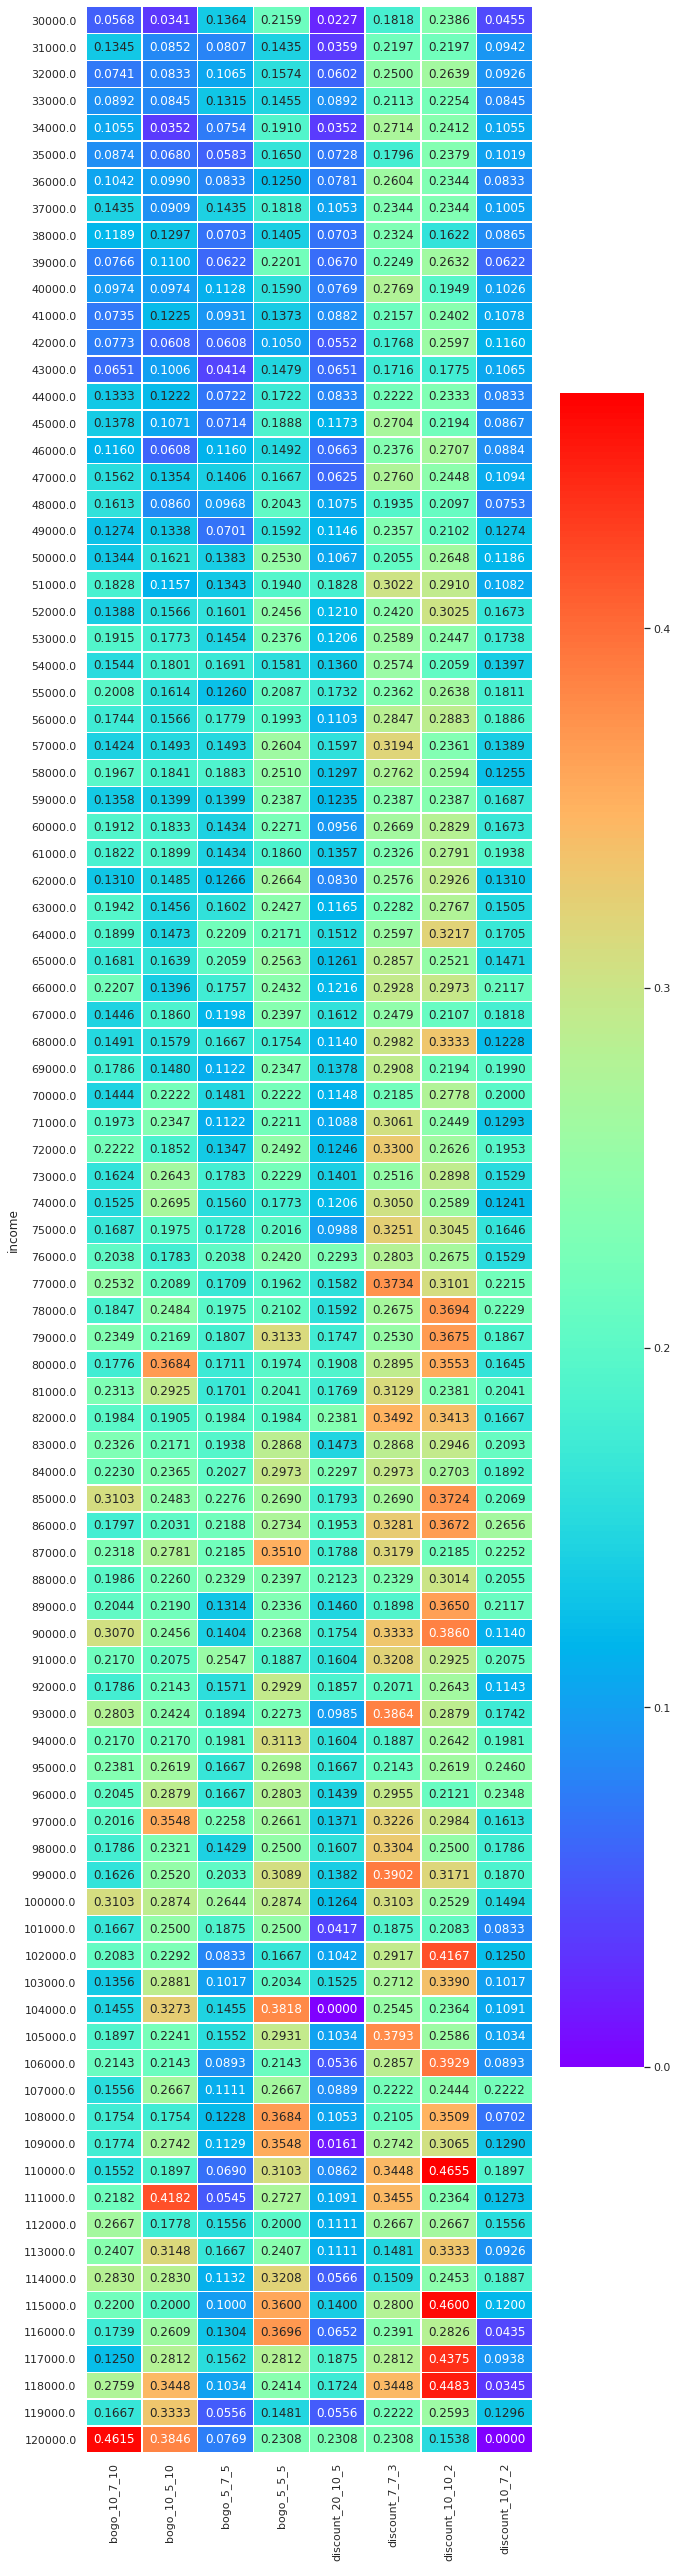

In [132]:
dfms_or_ov2_grp_income.columns = ['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

#create heatmap chart
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 45))
sns.heatmap(dfms_or_ov2_grp_income, annot=True, fmt=".4f", cmap='rainbow', linewidths=.5, ax=ax); 


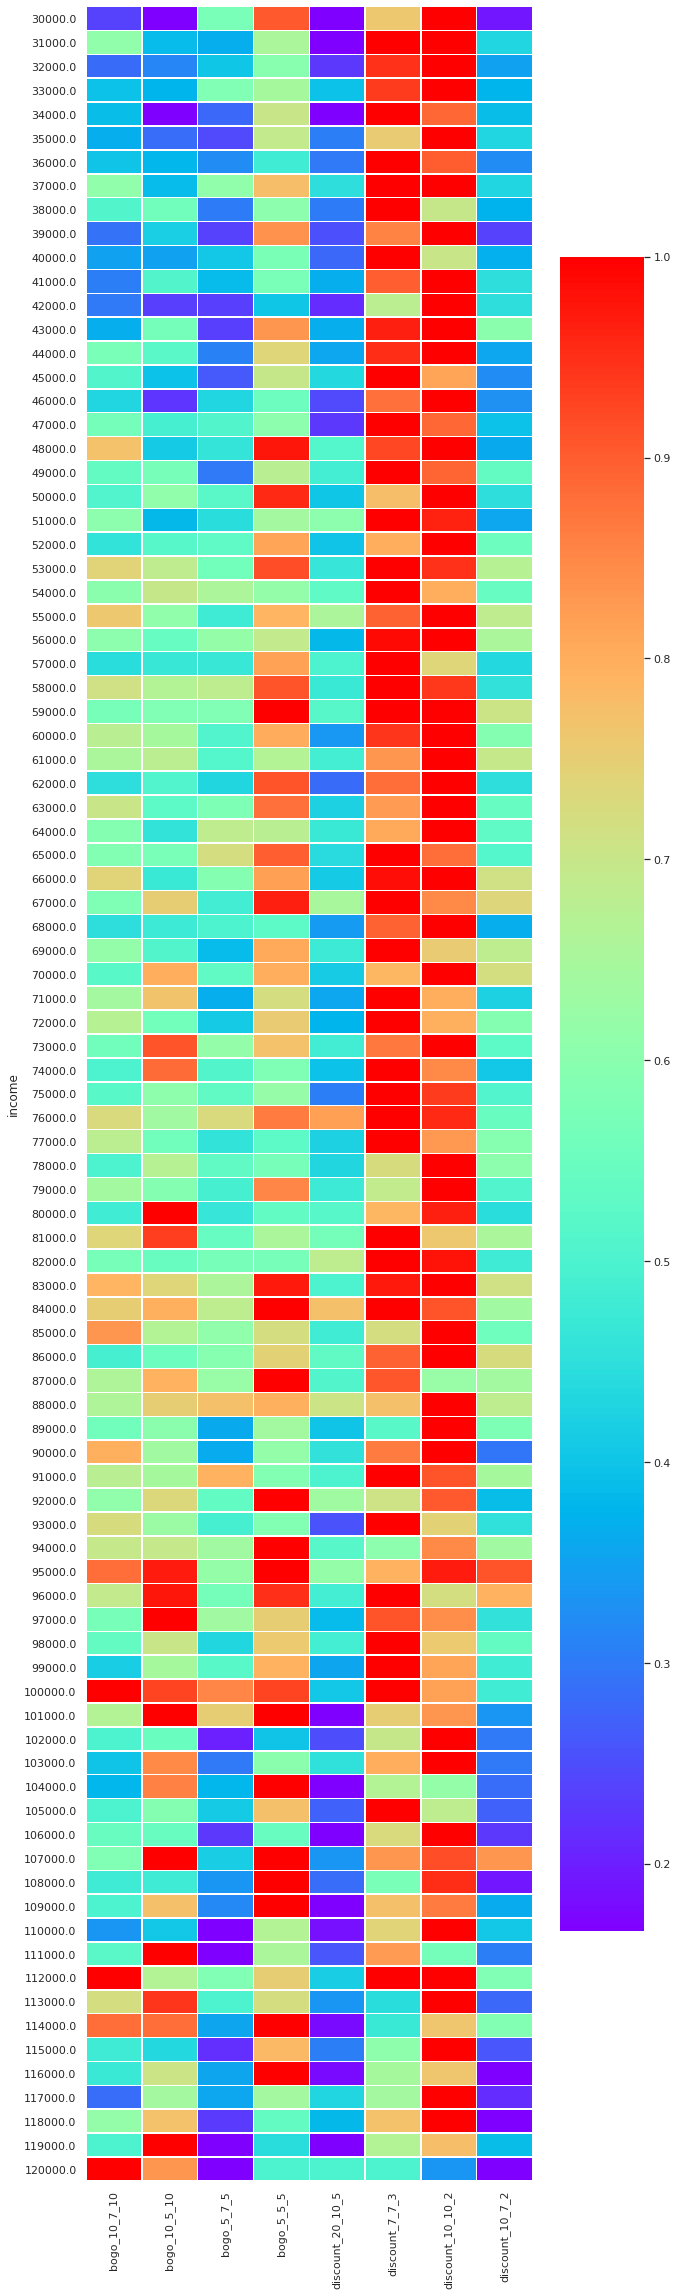

In [133]:
#create heatmap chart identifying most popular offer for each income group
sns.set_theme()
dfms_or_ov2_grp_income_row = dfms_or_ov2_grp_income.div(dfms_or_ov2_grp_income.max(axis=1), axis=0)
f, ax = plt.subplots(figsize=(10, 40))
sns.heatmap(dfms_or_ov2_grp_income_row, linewidths=.5 , cmap='rainbow',robust=True ,annot_kws = {'size':14});

In [134]:
dfms_or_ov2_grp_income = dfms_or_ov2_grp_income.reset_index()

print('For each of the offers these are the top 5 income groups that have used it the most (per person average):')
for x in range(1, 9):
    colname = dfms_or_ov2_grp_income.columns[x]
    print('')
    print('--------------Offer type: ' + colname + '-----------------------------------')
    dfms_or_ov2_grp_income = dfms_or_ov2_grp_income.sort_values(by=[dfms_or_ov2_grp_income.columns[x]], ascending=False)
    for y in range(0,5):
        print(str(y+1) + '.  -- ' + str(dfms_or_ov2_grp_income['income'].iloc[y]))


For each of the offers these are the top 5 income groups that have used it the most (per person average):

--------------Offer type: bogo_10_7_10-----------------------------------
1.  -- 120000.0
2.  -- 100000.0
3.  -- 85000.0
4.  -- 90000.0
5.  -- 114000.0

--------------Offer type: bogo_10_5_10-----------------------------------
1.  -- 111000.0
2.  -- 120000.0
3.  -- 80000.0
4.  -- 97000.0
5.  -- 118000.0

--------------Offer type: bogo_5_7_5-----------------------------------
1.  -- 100000.0
2.  -- 91000.0
3.  -- 88000.0
4.  -- 85000.0
5.  -- 97000.0

--------------Offer type: bogo_5_5_5-----------------------------------
1.  -- 104000.0
2.  -- 116000.0
3.  -- 108000.0
4.  -- 115000.0
5.  -- 109000.0

--------------Offer type: discount_20_10_5-----------------------------------
1.  -- 82000.0
2.  -- 120000.0
3.  -- 84000.0
4.  -- 76000.0
5.  -- 88000.0

--------------Offer type: discount_7_7_3-----------------------------------
1.  -- 99000.0
2.  -- 93000.0
3.  -- 105000.0
4.  -- 7

### Question: For each age catgory, which offer is the most popular --  groups that have used it the most(per person average)?

In [135]:
#creating dataframe that has grouping by age and the sum of offer recieved by them

dfms_or_ov2_grp1 = (dfms_or_ov2.groupby(['age'])
      .agg({'person_id':'count', 'bogo_10_7_10_cnt': 'sum', 'bogo_10_5_10_cnt': 'sum', 'bogo_5_7_5_cnt': 'sum', 
            'bogo_5_5_5_cnt': 'sum', 'discount_20_10_5_cnt': 'sum', 'discount_7_7_3_cnt': 'sum', 
            'discount_10_10_2_cnt': 'sum', 'discount_10_7_2_cnt': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_grp1['bogo_10_7_10_cnt_per_person'] = dfms_or_ov2_grp1['bogo_10_7_10_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['bogo_10_5_10_cnt_per_person'] = dfms_or_ov2_grp1['bogo_10_5_10_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['bogo_5_7_5_cnt_per_person'] = dfms_or_ov2_grp1['bogo_5_7_5_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['bogo_5_5_5_cnt_per_person'] = dfms_or_ov2_grp1['bogo_5_5_5_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['discount_20_10_5_cnt_per_person'] = dfms_or_ov2_grp1['discount_20_10_5_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['discount_7_7_3_cnt_per_person'] = dfms_or_ov2_grp1['discount_7_7_3_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['discount_10_10_2_cnt_per_person'] = dfms_or_ov2_grp1['discount_10_10_2_cnt']/dfms_or_ov2_grp1['person_count']
dfms_or_ov2_grp1['discount_10_7_2_cnt_per_person'] = dfms_or_ov2_grp1['discount_10_7_2_cnt']/dfms_or_ov2_grp1['person_count']

dfms_or_ov2_grp1_temp = dfms_or_ov2_grp1[['age', 'bogo_10_7_10_cnt_per_person', 'bogo_10_5_10_cnt_per_person', 'bogo_5_7_5_cnt_per_person', 
              'bogo_5_5_5_cnt_per_person', 'discount_20_10_5_cnt_per_person', 'discount_7_7_3_cnt_per_person', 
              'discount_10_10_2_cnt_per_person', 'discount_10_7_2_cnt_per_person']].copy()

dfms_or_ov2_grp1_temp.columns = ['age', 'bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

dfms_or_ov2_grp1_temp['max'] = dfms_or_ov2_grp1_temp[['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 
                                                      'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 
                                                      'discount_10_7_2']].idxmax(axis=1)

dfms_or_ov2_grp1_temp.head()


,age,bogo_10_7_10,bogo_10_5_10,bogo_5_7_5,bogo_5_5_5,discount_20_10_5,discount_7_7_3,discount_10_10_2,discount_10_7_2,max
0,18,0.100000,0.042857,0.071429,0.200000,0.114286,0.285714,0.200000,0.071429,discount_7_7_3
1,19,0.118519,0.111111,0.066667,0.118519,0.074074,0.185185,0.200000,0.074074,discount_10_10_2
2,20,0.103704,0.140741,0.059259,0.207407,0.066667,0.214815,0.177778,0.140741,discount_7_7_3
3,21,0.092857,0.100000,0.092857,0.214286,0.064286,0.221429,0.214286,0.085714,discount_7_7_3
4,22,0.129771,0.068702,0.091603,0.183206,0.061069,0.282443,0.183206,0.091603,discount_7_7_3


In [136]:
print('For each age catgory, here are the offer that are most popular for each of the category...')
print('')

for index, row in dfms_or_ov2_grp1_temp.iterrows():
    print('For age group ' + str(row['age']) + ' -- ' + row['max'] + ' is the best offer')        


For each age catgory, here are the offer that are most popular for each of the category...

For age group 18 -- discount_7_7_3 is the best offer
For age group 19 -- discount_10_10_2 is the best offer
For age group 20 -- discount_7_7_3 is the best offer
For age group 21 -- discount_7_7_3 is the best offer
For age group 22 -- discount_7_7_3 is the best offer
For age group 23 -- discount_7_7_3 is the best offer
For age group 24 -- discount_7_7_3 is the best offer
For age group 25 -- discount_10_10_2 is the best offer
For age group 26 -- discount_10_10_2 is the best offer
For age group 27 -- discount_10_10_2 is the best offer
For age group 28 -- discount_7_7_3 is the best offer
For age group 29 -- discount_7_7_3 is the best offer
For age group 30 -- discount_10_10_2 is the best offer
For age group 31 -- discount_7_7_3 is the best offer
For age group 32 -- discount_7_7_3 is the best offer
For age group 33 -- discount_10_10_2 is the best offer
For age group 34 -- discount_10_10_2 is the best

### Question: For each income catgory, which offer is the most popular --  groups that have used it the most(per person average)?

In [137]:

#creating dataframe that has grouping by income and the sum of offer recieved by them

dfms_or_ov2_grp2 = (dfms_or_ov2.groupby(['income'])
      .agg({'person_id':'count', 'bogo_10_7_10_cnt': 'sum', 'bogo_10_5_10_cnt': 'sum', 'bogo_5_7_5_cnt': 'sum', 
            'bogo_5_5_5_cnt': 'sum', 'discount_20_10_5_cnt': 'sum', 'discount_7_7_3_cnt': 'sum', 
            'discount_10_10_2_cnt': 'sum', 'discount_10_7_2_cnt': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_grp2['bogo_10_7_10_cnt_per_person'] = dfms_or_ov2_grp2['bogo_10_7_10_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['bogo_10_5_10_cnt_per_person'] = dfms_or_ov2_grp2['bogo_10_5_10_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['bogo_5_7_5_cnt_per_person'] = dfms_or_ov2_grp2['bogo_5_7_5_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['bogo_5_5_5_cnt_per_person'] = dfms_or_ov2_grp2['bogo_5_5_5_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['discount_20_10_5_cnt_per_person'] = dfms_or_ov2_grp2['discount_20_10_5_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['discount_7_7_3_cnt_per_person'] = dfms_or_ov2_grp2['discount_7_7_3_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['discount_10_10_2_cnt_per_person'] = dfms_or_ov2_grp2['discount_10_10_2_cnt']/dfms_or_ov2_grp2['person_count']
dfms_or_ov2_grp2['discount_10_7_2_cnt_per_person'] = dfms_or_ov2_grp2['discount_10_7_2_cnt']/dfms_or_ov2_grp2['person_count']

dfms_or_ov2_grp2_temp = dfms_or_ov2_grp2[['income', 'bogo_10_7_10_cnt_per_person', 'bogo_10_5_10_cnt_per_person', 'bogo_5_7_5_cnt_per_person', 
              'bogo_5_5_5_cnt_per_person', 'discount_20_10_5_cnt_per_person', 'discount_7_7_3_cnt_per_person', 
              'discount_10_10_2_cnt_per_person', 'discount_10_7_2_cnt_per_person']].copy()

dfms_or_ov2_grp2_temp.columns = ['income', 'bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

dfms_or_ov2_grp2_temp['max'] = dfms_or_ov2_grp2_temp[['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 
                                                      'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 
                                                      'discount_10_7_2']].idxmax(axis=1)

dfms_or_ov2_grp2_temp.head()

,income,bogo_10_7_10,bogo_10_5_10,bogo_5_7_5,bogo_5_5_5,discount_20_10_5,discount_7_7_3,discount_10_10_2,discount_10_7_2,max
0,30000.0,0.056818,0.034091,0.136364,0.215909,0.022727,0.181818,0.238636,0.045455,discount_10_10_2
1,31000.0,0.134529,0.085202,0.080717,0.143498,0.035874,0.219731,0.219731,0.094170,discount_7_7_3
2,32000.0,0.074074,0.083333,0.106481,0.157407,0.060185,0.250000,0.263889,0.092593,discount_10_10_2
3,33000.0,0.089202,0.084507,0.131455,0.145540,0.089202,0.211268,0.225352,0.084507,discount_10_10_2
4,34000.0,0.105528,0.035176,0.075377,0.190955,0.035176,0.271357,0.241206,0.105528,discount_7_7_3


In [138]:
print('For each income catgory, here are the offer that are most popular for each of the category...')
print('')

for index, row in dfms_or_ov2_grp2_temp.iterrows():
    print('For income group ' + str(row['income']) + ' -- ' + row['max'] + ' is the best offer')        


For each income catgory, here are the offer that are most popular for each of the category...

For income group 30000.0 -- discount_10_10_2 is the best offer
For income group 31000.0 -- discount_7_7_3 is the best offer
For income group 32000.0 -- discount_10_10_2 is the best offer
For income group 33000.0 -- discount_10_10_2 is the best offer
For income group 34000.0 -- discount_7_7_3 is the best offer
For income group 35000.0 -- discount_10_10_2 is the best offer
For income group 36000.0 -- discount_7_7_3 is the best offer
For income group 37000.0 -- discount_7_7_3 is the best offer
For income group 38000.0 -- discount_7_7_3 is the best offer
For income group 39000.0 -- discount_10_10_2 is the best offer
For income group 40000.0 -- discount_7_7_3 is the best offer
For income group 41000.0 -- discount_10_10_2 is the best offer
For income group 42000.0 -- discount_10_10_2 is the best offer
For income group 43000.0 -- discount_10_10_2 is the best offer
For income group 44000.0 -- discoun

### Question: For each "gender, age" catgory, which offer is the most popular --  groups that have used it the most(per person average)?

In [139]:
#creating dataframe that has grouping by gender, age and the sum of offer recieved by them

dfms_or_ov2_grp3 = (dfms_or_ov2.groupby(['gender', 'age'])
      .agg({'person_id':'count', 'bogo_10_7_10_cnt': 'sum', 'bogo_10_5_10_cnt': 'sum', 'bogo_5_7_5_cnt': 'sum', 
            'bogo_5_5_5_cnt': 'sum', 'discount_20_10_5_cnt': 'sum', 'discount_7_7_3_cnt': 'sum', 
            'discount_10_10_2_cnt': 'sum', 'discount_10_7_2_cnt': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_grp3['bogo_10_7_10_cnt_per_person'] = dfms_or_ov2_grp3['bogo_10_7_10_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['bogo_10_5_10_cnt_per_person'] = dfms_or_ov2_grp3['bogo_10_5_10_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['bogo_5_7_5_cnt_per_person'] = dfms_or_ov2_grp3['bogo_5_7_5_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['bogo_5_5_5_cnt_per_person'] = dfms_or_ov2_grp3['bogo_5_5_5_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['discount_20_10_5_cnt_per_person'] = dfms_or_ov2_grp3['discount_20_10_5_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['discount_7_7_3_cnt_per_person'] = dfms_or_ov2_grp3['discount_7_7_3_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['discount_10_10_2_cnt_per_person'] = dfms_or_ov2_grp3['discount_10_10_2_cnt']/dfms_or_ov2_grp3['person_count']
dfms_or_ov2_grp3['discount_10_7_2_cnt_per_person'] = dfms_or_ov2_grp3['discount_10_7_2_cnt']/dfms_or_ov2_grp3['person_count']

dfms_or_ov2_grp3_temp = dfms_or_ov2_grp3[['gender', 'age', 'bogo_10_7_10_cnt_per_person', 'bogo_10_5_10_cnt_per_person', 'bogo_5_7_5_cnt_per_person', 
              'bogo_5_5_5_cnt_per_person', 'discount_20_10_5_cnt_per_person', 'discount_7_7_3_cnt_per_person', 
              'discount_10_10_2_cnt_per_person', 'discount_10_7_2_cnt_per_person']].copy()

dfms_or_ov2_grp3_temp.columns = ['gender', 'age', 'bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

dfms_or_ov2_grp3_temp['max'] = dfms_or_ov2_grp3_temp[['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 
                                                      'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 
                                                      'discount_10_7_2']].idxmax(axis=1)

dfms_or_ov2_grp3_temp.head()


,gender,age,bogo_10_7_10,bogo_10_5_10,bogo_5_7_5,bogo_5_5_5,discount_20_10_5,discount_7_7_3,discount_10_10_2,discount_10_7_2,max
0,F,18,0.142857,0.071429,0.000000,0.285714,0.000000,0.214286,0.000000,0.071429,bogo_5_5_5
1,F,19,0.193548,0.225806,0.000000,0.225806,0.064516,0.129032,0.193548,0.129032,bogo_10_5_10
2,F,20,0.200000,0.314286,0.028571,0.228571,0.085714,0.171429,0.200000,0.200000,bogo_10_5_10
3,F,21,0.073171,0.170732,0.195122,0.317073,0.097561,0.292683,0.341463,0.097561,discount_10_10_2
4,F,22,0.173913,0.021739,0.065217,0.217391,0.043478,0.347826,0.152174,0.130435,discount_7_7_3


In [140]:
print('For each "gender, age" catgory, here are the offer that are most popular for each of the category...')
print('')

for index, row in dfms_or_ov2_grp3_temp.iterrows():
    print('For gender ' + row['gender'] + ' of age ' + str(row['age']) + ' -- ' + row['max'] + ' is the best offer')        


For each "gender, age" catgory, here are the offer that are most popular for each of the category...

For gender F of age 18 -- bogo_5_5_5 is the best offer
For gender F of age 19 -- bogo_10_5_10 is the best offer
For gender F of age 20 -- bogo_10_5_10 is the best offer
For gender F of age 21 -- discount_10_10_2 is the best offer
For gender F of age 22 -- discount_7_7_3 is the best offer
For gender F of age 23 -- discount_7_7_3 is the best offer
For gender F of age 24 -- discount_7_7_3 is the best offer
For gender F of age 25 -- discount_10_10_2 is the best offer
For gender F of age 26 -- discount_10_10_2 is the best offer
For gender F of age 27 -- discount_10_10_2 is the best offer
For gender F of age 28 -- discount_7_7_3 is the best offer
For gender F of age 29 -- bogo_10_7_10 is the best offer
For gender F of age 30 -- bogo_5_5_5 is the best offer
For gender F of age 31 -- discount_7_7_3 is the best offer
For gender F of age 32 -- bogo_10_7_10 is the best offer
For gender F of age 3

For gender O of age 66 -- discount_7_7_3 is the best offer
For gender O of age 67 -- bogo_5_7_5 is the best offer
For gender O of age 68 -- bogo_10_5_10 is the best offer
For gender O of age 69 -- bogo_10_7_10 is the best offer
For gender O of age 70 -- bogo_10_7_10 is the best offer
For gender O of age 71 -- bogo_5_7_5 is the best offer
For gender O of age 72 -- discount_10_10_2 is the best offer
For gender O of age 73 -- bogo_5_7_5 is the best offer
For gender O of age 74 -- bogo_10_7_10 is the best offer
For gender O of age 75 -- bogo_10_7_10 is the best offer
For gender O of age 76 -- discount_10_10_2 is the best offer
For gender O of age 77 -- bogo_5_7_5 is the best offer
For gender O of age 79 -- bogo_10_7_10 is the best offer
For gender O of age 80 -- bogo_10_7_10 is the best offer
For gender O of age 81 -- bogo_5_5_5 is the best offer
For gender O of age 82 -- bogo_10_5_10 is the best offer
For gender O of age 84 -- bogo_10_7_10 is the best offer
For gender O of age 85 -- bogo_

### Question: For each "gender, income" catgory, which offer is the most popular --  groups that have used it the most(per person average)?

In [141]:

#creating dataframe that has grouping by gender, income and the sum of offer recieved by them

dfms_or_ov2_grp4 = (dfms_or_ov2.groupby(['gender', 'income'])
      .agg({'person_id':'count', 'bogo_10_7_10_cnt': 'sum', 'bogo_10_5_10_cnt': 'sum', 'bogo_5_7_5_cnt': 'sum', 
            'bogo_5_5_5_cnt': 'sum', 'discount_20_10_5_cnt': 'sum', 'discount_7_7_3_cnt': 'sum', 
            'discount_10_10_2_cnt': 'sum', 'discount_10_7_2_cnt': 'sum'})
      .reset_index().rename(columns={'person_id':'person_count'}))

dfms_or_ov2_grp4['bogo_10_7_10_cnt_per_person'] = dfms_or_ov2_grp4['bogo_10_7_10_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['bogo_10_5_10_cnt_per_person'] = dfms_or_ov2_grp4['bogo_10_5_10_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['bogo_5_7_5_cnt_per_person'] = dfms_or_ov2_grp4['bogo_5_7_5_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['bogo_5_5_5_cnt_per_person'] = dfms_or_ov2_grp4['bogo_5_5_5_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['discount_20_10_5_cnt_per_person'] = dfms_or_ov2_grp4['discount_20_10_5_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['discount_7_7_3_cnt_per_person'] = dfms_or_ov2_grp4['discount_7_7_3_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['discount_10_10_2_cnt_per_person'] = dfms_or_ov2_grp4['discount_10_10_2_cnt']/dfms_or_ov2_grp4['person_count']
dfms_or_ov2_grp4['discount_10_7_2_cnt_per_person'] = dfms_or_ov2_grp4['discount_10_7_2_cnt']/dfms_or_ov2_grp4['person_count']

dfms_or_ov2_grp4_temp = dfms_or_ov2_grp4[['gender', 'income', 'bogo_10_7_10_cnt_per_person', 'bogo_10_5_10_cnt_per_person', 'bogo_5_7_5_cnt_per_person', 
              'bogo_5_5_5_cnt_per_person', 'discount_20_10_5_cnt_per_person', 'discount_7_7_3_cnt_per_person', 
              'discount_10_10_2_cnt_per_person', 'discount_10_7_2_cnt_per_person']].copy()

dfms_or_ov2_grp4_temp.columns = ['gender', 'income', 'bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 'discount_10_7_2']

dfms_or_ov2_grp4_temp['max'] = dfms_or_ov2_grp4_temp[['bogo_10_7_10', 'bogo_10_5_10', 'bogo_5_7_5', 'bogo_5_5_5', 
                                                      'discount_20_10_5', 'discount_7_7_3', 'discount_10_10_2', 
                                                      'discount_10_7_2']].idxmax(axis=1)

dfms_or_ov2_grp4_temp.head()

,gender,income,bogo_10_7_10,bogo_10_5_10,bogo_5_7_5,bogo_5_5_5,discount_20_10_5,discount_7_7_3,discount_10_10_2,discount_10_7_2,max
0,F,30000.0,0.136364,0.000000,0.045455,0.181818,0.045455,0.136364,0.136364,0.090909,bogo_5_5_5
1,F,31000.0,0.138889,0.111111,0.097222,0.152778,0.041667,0.250000,0.291667,0.083333,discount_10_10_2
2,F,32000.0,0.066667,0.100000,0.133333,0.233333,0.083333,0.316667,0.333333,0.116667,discount_10_10_2
3,F,33000.0,0.163934,0.196721,0.180328,0.229508,0.081967,0.245902,0.327869,0.098361,discount_10_10_2
4,F,34000.0,0.188679,0.037736,0.037736,0.188679,0.037736,0.283019,0.245283,0.113208,discount_7_7_3


In [142]:
print('For each "gender, income" catgory, here are the offer that are most popular for each of the category...')
print('')

for index, row in dfms_or_ov2_grp4_temp.iterrows():
    print('For gender ' + row['gender'] + ' having income ' + str(row['income']) + ' -- ' + row['max'] + ' is the best offer')        


For each "gender, income" catgory, here are the offer that are most popular for each of the category...

For gender F having income 30000.0 -- bogo_5_5_5 is the best offer
For gender F having income 31000.0 -- discount_10_10_2 is the best offer
For gender F having income 32000.0 -- discount_10_10_2 is the best offer
For gender F having income 33000.0 -- discount_10_10_2 is the best offer
For gender F having income 34000.0 -- discount_7_7_3 is the best offer
For gender F having income 35000.0 -- discount_10_10_2 is the best offer
For gender F having income 36000.0 -- discount_7_7_3 is the best offer
For gender F having income 37000.0 -- discount_7_7_3 is the best offer
For gender F having income 38000.0 -- bogo_5_5_5 is the best offer
For gender F having income 39000.0 -- discount_10_10_2 is the best offer
For gender F having income 40000.0 -- discount_7_7_3 is the best offer
For gender F having income 41000.0 -- discount_7_7_3 is the best offer
For gender F having income 42000.0 -- dis

### Conclusion

Even though the dataset intially seemed to to fairly stright forward, there are numorous possibilities of evaluating and further drawing conclusions from it. 

My approach in solving the problems was to look at the data analyze it come up with a set of possible option on how to possibly increase the sales by targetting certain demographics.

In this evaluation I tried answering some question.

* What is the best offer for the overall target audience?

discount_10_10_2 offer is the best offer overall for all customers. This is Discount that requires amount 10 to be spent in a period of 10 days with a reward of 2 being given. Other two in top 3 were discount_7_7_3 and bogo_5_5_5.

* What is/are the best offer(s) at an individual personalized level? 
    * Based on Age
    * Based on Income
    * Based on Gender & Age
    * Based on Gender & Income

For each of these demographic groupings I have a set of recommendations that would help target the offers for higher sales for Starbucks.

* Where do we have the opportunity to increase the number of offers being sent for certain demographics to increase sales?

I looked at the ratio of offer recieved to offer viewed and came up with some findings that look for pockets of demographics where the ration is higher comepared to rest.

* How much reward was given to individuals that did not view the offers sent to them?

We also see that some of the customers are getting the rewards even when they are not viewing th offers. I looked at the total amount of reward that was given in this scenario. If the rewards being given is driven by tracking all customers who were sent the offer out, then it would be better not to send any offer to them. 


